In [1]:
# Read this text

#     Just like it was done in the easy problem we will use the customer and occupation code data bases. But now  we are going
#     to leverage the transaction data.
    
#     This transaction data is composed by 2800 clients of all the 4000 in the customer train and we have monthly and
#     per type of transaction data.
    
#     Some clients appear for 13, 12,11 months while others less than 6 times, this can be problematic if we compute 
#     based on statistics.
    
#     Some of the treatements were to group amex and visa into one new transaction type called "credit_card", besides that 
#     all the treatment of the easy problem were applied here.
    
#     The features that were evaluate were all based on the in_amt, out_amt, in_cnt, out_cnt:
#         classical statistics calculated both at the client x transaction level as well as at the client level
#         flag for breach of threshold defined as mean + 1*std or mean + 1*std
#         the number of digits in the the amounts of transactions, the number of zeros to the length of the number
        
#         and finally compute statistics prior the threshold breach and post the threshold breach to assess for change in 
#         behaviour
    
#     the statistics and features were then pivoted to columns keeping the client as the index, the shape of the dataframe
#     is something like the example
    
#     client | transaction_type | in_amt
#     xxxxxx   cash                1000      ----->  client | in_amt_cash | in_amt_carc
#     xxxxxx   card                50                 xxxxx    1000           50
     
    
#     The models utilized were the logistic regression and random forest, the other ones are not suitable for the problem
#     and would take too long (SVM)
    
#     Interaction terms were assessed for the logistic regression with success and selected using L1 regularization
    
#     Since the data is small, augmenting the data is a viable option, to do all the data preparation was done on
#     clients that had more than 6 month of data and by removing, iteratively the last, second to last months and so forth, 
#     until 6 months were remove while keeping the restriction of having at least 6 months of observation
    
#     As a result this data augmentation improved the performance of the models simply because for a human being one month
#     of data will not change their conclusion but for an algorithm, having more data helps to generalize better since the 
#     data is similar but no equal. 
    
#     The optimal amount of months were 4, more than that there were decreases in model performance.
    
#     The logistic regression had a high recall while the random forest had a high precision in this new data set
#     combining them would allow for a good mix of recall and precision to solve the issue

#         Since random forests are sensitive to hyperparamter, a hyperparamter tuning was performed to maximize
#     the AUC on the validation test adjusted by the gap between the AUC in validation and AUC in training 
#     to avoid overfitting
    
#     The optimal weight for logistic was defined based on the combination that maximized the AUC of the predictions
    



In [2]:

# importing packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import glob
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.cluster import *
from sklearn.preprocessing import *
from sklearn.neighbors import *
from sklearn.decomposition import *
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import *
import tqdm
import statsmodels.api as sm
import itertools
pd.set_option("display.max_column", 999)
pd.set_option("display.max_row", 100)
from contextlib import contextmanager

from joblib import Parallel, delayed
from functools import partial
import gc

In [3]:
@contextmanager
def timer(process_name):
    t0 = time.time()
    print("Beginning %s"%(process_name))
    yield

    if (time.time() - t0)/60 < 1:
        print("Tempo execução %s = %.2f segundos" %(process_name, time.time() - t0  ))
    else:
        print("Tempo execução %s = %.2f minutos" %(process_name, (time.time() - t0)/60 ))


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [4]:
# ----------auxiliar functions--------------

def drop_collinear(df, level = 0.8):
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > level)]

    return to_drop

def number_digits_integer(x):              
    return 0 if np.isnan(x) else len(str(int(x//1)))
    
def number_zero_digits_integer(x):              
    return 0 if np.isnan(x) else len([ c for c in str(int(x//1)) if int(c) ==0  ])

In [5]:
def feature_engineering(df):
    
    
    string_columns = ['jurisdiction_code',
                    'client_type_aml',
                    'industry_code_aml',
                    'occupation_code_aml',
                    'country_of_domicile_aml',
                    'occupation_status_code_aml',
                    'customer_status_aml',
                      'primary_ownership_flag', 
                      'relationship_type']
    
    value_columns = ['PCD_CDA',
                     'PCD_CMS',
                     'PCD_CRC',
#                      'PCD_LIN',
                     'PCD_LLC',
                     'PCD_MOR',
                     'PCD_MUF',
                     'PCD_SAV',
                     'PCD_SDB',
                     'PCD_TED',
                     'SRV_FLG',
                     'SRV_FSL',
                     'SRV_ILC',
                     'SRV_LOC',
                     'SRV_NLG',
                     'SRV_NSL',
#                      'SRV_RDC',
                     'SRV_TRF',
#                      'SRV_WIP',
                    ]
    
    

    for s in string_columns:
        
        
        df[f'{s}_treated'] = df[s].fillna('01_null').map(lambda x: x.lower().strip().replace(' ','_'))       
        
        df[f'{s}_freq'] = df.groupby(s)[s].transform('count')/len(df)
        
        
        df[f'{s}_grouped'] = df[f'{s}_treated']
        
        if len(df[f'{s}_grouped'].unique()) > 5:
            df[f'{s}_grouped'] = np.where( df[f'{s}_freq'] >=0.01, df[f'{s}_treated'], '02_other')
            df[f'{s}_grouped'] = np.where( df[f'{s}_treated'] == 'null', '01_null', df[f'{s}_grouped'])
    
    
    
    for v in value_columns:
        df[f'{v}_treated']  = df[v].fillna(0)
        
    
    return df
        

    
def run_cross_validation(dataset, features, target, cv_indices, model):
    
    results=[]
#     for train_idx, val_idx in tqdm.tqdm_notebook(cv_splitter.split(dataset, dataset[target])):
    for train_idx, val_idx in tqdm.tqdm_notebook(cv_indices):
        
        xtrain = dataset.loc[train_idx,features].copy()
        ytrain = dataset.loc[train_idx,target].copy().values

        xvalid = dataset.loc[val_idx,features].copy()
        yvalid = dataset.loc[val_idx,target].copy().values
        
        model.fit(xtrain,ytrain)
        train_proba = model.predict_proba(xtrain)[:,1]
        valid_proba = model.predict_proba(xvalid)[:,1]
                       
        auc_train = roc_auc_score(ytrain, train_proba)
        auc_valid = roc_auc_score(yvalid, valid_proba)
        
        
        train_pred = model.predict(xtrain)
        valid_pred = model.predict(xvalid)
        
        
        accuracy_train = accuracy_score(ytrain, train_pred)
        accuracy_valid = accuracy_score(yvalid, valid_pred)
       
        f1_train = f1_score(ytrain, train_pred)
        f1_valid = f1_score(yvalid, valid_pred)
        
        recall_train = recall_score(ytrain, train_pred)
        recall_valid = recall_score(yvalid, valid_pred)

        precision_train = precision_score(ytrain, train_pred)
        precision_valid = precision_score(yvalid, valid_pred)
        

        results.append([auc_train,auc_valid,accuracy_train,accuracy_valid,f1_train,f1_valid,recall_train, recall_valid,precision_train,precision_valid])

    results = pd.DataFrame(results,columns = ['auc_train','auc_valid','accuracy_train','accuracy_valid',
                                              'f1_train','f1_valid','recall_train', 'recall_valid','precision_train','precision_valid'])
    return results
            
        
        
    

In [6]:
def prep_data_easy_problem(cust_train, occupation_code):
    #function to replicate data prep on the smaller data set for merging latter on
    # merging ocuppaction code with cust_train to get labels for occupation codes
    cust_train2 = cust_train.merge(occupation_code,left_on='occupation_code_aml', right_on = ['Occupation Code'])
    
        # mining/natural resources there are little observations -> going to aggregate into Engineering
    # manual labour there are little observations -> going to aggregate into General

    dict_temp = {
        'mining/natural resources':'Engineering',
        'Manual Labour':'General'

    }


    cust_train2['Sector2'] = cust_train2['Sector'].map(dict_temp).fillna(cust_train2['Sector'])
    cust_train2['Sector2'].value_counts()

    # creating list to drop all columns with only nulls
    to_drop = cust_train2.isnull().sum()/len(cust_train2)
    to_drop = to_drop[to_drop >=0.99].index.values.tolist()
    to_drop

    # drop columns with only 1 unique value
    only_1_value = cust_train.apply(lambda x: x.unique().size)

    only_1_value= only_1_value[only_1_value==1].index.values.tolist()

    # adding columns with one value to drop
    to_drop = to_drop+only_1_value
    to_drop = list(set(to_drop))
    to_drop

    # adjust the other columns for null values usiing feature_engineering functions
    cust_train2 = feature_engineering(cust_train2)


    # categorical columns to create dummy variables
    string_columns = [

                    'Sector2',
                    'country_of_domicile_aml_grouped',
                      'primary_ownership_flag_grouped', 
                      'relationship_type_grouped']

    # numerical columns
    value_columns = ['PCD_CDA',
                     'PCD_CMS',
                     'PCD_CRC',
                     'PCD_LLC',
                     'PCD_MOR',
                     'PCD_MUF',
                     'PCD_SAV',
                     'PCD_SDB',
                     'PCD_TED',
                     'SRV_FLG',
                     'SRV_FSL',
                     'SRV_ILC',
                     'SRV_LOC',
                     'SRV_NLG',
                     'SRV_NSL',
                     'SRV_TRF',
                    ]


    # selecting numerical columns for the model
    # not in the drop list, end with treated and start with the value_columns list
    numerical_features = [c for c in cust_train2.columns if (not c.startswith(tuple(to_drop))) & (c.endswith('treated')) & (c.startswith(tuple(value_columns)))]
    numerical_features


    cust_train3 = cust_train2.copy()
    # creating dummy columns, drop first observation -> will be either other category of null value
    cust_train3 = pd.get_dummies(cust_train3,columns = string_columns,drop_first=True)
    cust_train3.head()

    dummy_columns = [c for c in cust_train3 if c.startswith(tuple(string_columns))]
    dummy_columns

    # create feature list
    features = dummy_columns.copy() + numerical_features.copy()
    len(features),features

    # results are not good, we will evaluate interaction terms: numerical x numerical
    interaction_numerical = list(itertools.product(numerical_features, numerical_features ))
    interaction_numerical = interaction_numerical[0: len(interaction_numerical)//2]
    # remove quadratic terms, for now
    interaction_numerical = [c for c in interaction_numerical if c[0] != c[1]]

    for x1, x2 in interaction_numerical:
        cust_train3[f'{x1}_{x2}']  = cust_train3[x1]*cust_train3[x2]

    interaction_numerical_terms = ['_'.join(c) for c in interaction_numerical]
    # results are not good, we will evaluate interaction terms: dummy x numerical
    interaction_terms = list(itertools.product(dummy_columns, numerical_features + interaction_numerical_terms))
    interaction_terms = interaction_terms[0: len(interaction_terms)//2]



    len(interaction_terms)

    for x1, x2 in interaction_terms:
        cust_train3[f'{x1}_{x2}']  = cust_train3[x1]*cust_train3[x2]

    interaction_terms_columns = ['_'.join(c) for c in interaction_terms]
    features2 = features.copy() + interaction_terms_columns.copy() + interaction_numerical_terms.copy()
    features2

    return cust_train3, dummy_columns,features,features2

In [7]:

def data_prep(datain, groupbykey): 
    transaction_train = datain.copy()
    #     transaction_train.sort_values(by=['customer_id_mskd','month','trsactn_type'],inplace=True)
    #     transaction_train.reset_index(inplace=True)
    # total amount and cont
    transaction_train['total_amt'] = transaction_train['in_amt'].fillna(0) + transaction_train['out_amt'].fillna(0)
    transaction_train['total_cnt'] = transaction_train['in_cnt'].fillna(0) + transaction_train['out_cnt'].fillna(0)

    # ----- in amt
    # length of number
    transaction_train['number_digits_integer_in_amt'] = transaction_train['in_amt'].map(lambda x: number_digits_integer(x) )
    # number of zeros in the number
    transaction_train['number_zero_digits_integer_in_amt'] = transaction_train['in_amt'].map(lambda x: number_zero_digits_integer(x) )
    # ratio of zeros to the length of the number
    transaction_train['number_zero_digits_integer_in_amt/number_digits_integer_in_amt'] = transaction_train['number_zero_digits_integer_in_amt']/transaction_train['number_digits_integer_in_amt']

    # ----- out amt
    # length of number
    transaction_train['number_digits_integer_out_amt'] = transaction_train['out_amt'].map(lambda x: number_digits_integer(x) )
    # number of zeros in the number
    transaction_train['number_zero_digits_integer_out_amt'] = transaction_train['out_amt'].map(lambda x: number_zero_digits_integer(x) )
    # ratio of zeros to the length of the number
    transaction_train['number_zero_digits_integer_out_amt/number_digits_integer_out_amt'] = transaction_train['number_zero_digits_integer_out_amt']/transaction_train['number_digits_integer_out_amt']
    transaction_train.head(20)


    # ----- total amt
    # length of number
    transaction_train['number_digits_integer_total_amt'] = transaction_train['total_amt'].map(lambda x: number_digits_integer(x) )
    # number of zeros in the number
    transaction_train['number_zero_digits_integer_total_amt'] = transaction_train['total_amt'].map(lambda x: number_zero_digits_integer(x) )
    # ratio of zeros to the length of the number
    transaction_train['number_zero_digits_integer_total_amt/number_digits_integer_total_amt'] = transaction_train['number_zero_digits_integer_total_amt']/transaction_train['number_digits_integer_total_amt']
    transaction_train.head(20)

    # ratio of in_amt/out_amt
    transaction_train['in_amt/out_amt'] = (transaction_train['in_amt']/transaction_train['out_amt']).replace(np.inf,np.nan)

    # ratio of in_cnt/out_cnt
    transaction_train['in_cnt/out_cnt'] = (transaction_train['in_cnt']/transaction_train['out_cnt']).replace(np.inf,np.nan)
    transaction_train.head()
    
    transaction_train['avg_in_amt'] = transaction_train['in_amt']/transaction_train['in_cnt']
    transaction_train['avg_out_amt'] = transaction_train['out_amt']/transaction_train['out_cnt']

    def max_to_median(x):
        out = np.max(x)/np.median(x)
        out = 1 if np.isnan(out) else out
        return out   
    def coefficient_of_variation(x):
        return np.std(x)/(np.mean(x)+0.001) 

    funcs = ['mean','std','max','median']
    columns=['in_amt','out_amt','total_amt','in_cnt','out_cnt','total_cnt','avg_in_amt','avg_out_amt']

    x=transaction_train.groupby(groupbykey)[columns].agg(funcs)


    x.columns=['_'.join(c) for c in x.columns]

    for col in columns:
        x[f'{col}_coefficient_of_variation'] = x[f'{col}_std']/(x[f'{col}_mean']+0.001)
        x[f'{col}_max_to_median'] = x[f'{col}_max']/(x[f'{col}_median']+0.001)
        

    x.head()

    transaction_train.set_index(['customer_id_mskd','trsactn_type'],inplace=True)
    transaction_train=transaction_train.join(x).reset_index()
    transaction_train.head()




    # going to flag if the amount was greater than the global 
    # mean + std dev to count how many times the client broke this threshold

    transaction_train['in_amt_greater_than_mean_plus_1_std'] = (transaction_train['in_amt'] >\
                                                                       transaction_train['in_amt_mean']\
                                                                       + transaction_train['in_amt_std']).astype(int)

    transaction_train['in_amt_greater_than_mean_plus_2_std'] = (transaction_train['in_amt'] >\
                                                                       transaction_train['in_amt_mean'] +\
                                                                       2*transaction_train['in_amt_std']).astype(int)


    transaction_train['out_amt_greater_than_mean_plus_1_std'] = (transaction_train['out_amt'] > \
                                                                 transaction_train['out_amt_mean'] +\
                                                                 transaction_train['out_amt_std']).astype(int)

    transaction_train['out_amt_greater_than_mean_plus_2_std'] = (transaction_train['out_amt'] >\
                                                                 transaction_train['out_amt_mean']\
                                                                 + 2*transaction_train['out_amt_std']).astype(int)

    transaction_train['in_cnt_greater_than_mean_plus_1_std'] = (transaction_train['in_cnt'] >\
                                                                transaction_train['in_cnt_mean']\
                                                                + transaction_train['in_cnt_std']).astype(int)


    transaction_train['in_cnt_greater_than_mean_plus_2_std'] = (transaction_train['in_cnt'] >\
                                                                transaction_train['in_cnt_mean']\
                                                                + 2*transaction_train['in_cnt_std']).astype(int)

    transaction_train['out_cnt_greater_than_mean_plus_1_std'] = (transaction_train['out_cnt'] >\
                                                                 transaction_train['out_cnt_mean'] \
                                                                 + transaction_train['out_cnt_std']).astype(int)

    transaction_train['out_cnt_greater_than_mean_plus_2_std'] = (transaction_train['out_cnt'] >\
                                                                        transaction_train['out_cnt_mean']\
                                                                        + 2*transaction_train['out_cnt_std']).astype(int)


    transaction_train['total_amt_greater_than_mean_plus_1_std'] = (transaction_train['total_amt'] >\
                                                                   transaction_train['total_amt_mean']\
                                                                   + transaction_train['total_amt_std']).astype(int)

    transaction_train['total_amt_greater_than_mean_plus_2_std'] = (transaction_train['total_amt'] >\
                                                                          transaction_train['total_amt_mean']\
                                                                          + 2*transaction_train['total_amt_std']).astype(int)

    transaction_train['total_cnt_greater_than_mean_plus_1_std'] = (transaction_train['total_cnt'] >\
                                                                          transaction_train['total_cnt_mean'] \
                                                                          + transaction_train['total_cnt_std']).astype(int)

    transaction_train['total_cnt_greater_than_mean_plus_2_std'] = (transaction_train['total_cnt'] >\
                                                                   transaction_train['total_cnt_mean'] \
                                                                   + 2*transaction_train['total_cnt_std']).astype(int)




    # now with the threshold breaches calculated, we will calculate the average, mean and standard deviation both prior and post the breach 
    # to assess if there is a change in behavior
    transaction_train['month_number'] = transaction_train['month'].map(lambda x: x.replace('-','')).astype(int)
    transaction_train = transaction_train.sort_values(by = ['customer_id_mskd','trsactn_type','month']).reset_index()
    transaction_train.head()

    def create_prior_and_post_breach_columns(data, breach_threshold, values=[],groupbykey = []):

        # compute the month in which the breach occured per type of transaction
        data[f'month_break_{breach_threshold}'] = data[breach_threshold]*transaction_train['month_number']

        # going to replace 0 as np.nan to fill the null values sequentially, probably there are more than 1 instances in which there were breaches
        data[f'month_break_{breach_threshold}'].replace(0,np.nan,inplace=True)
        #         data[f'month_break_{breach_threshold}'].fillna(method='ffill',inplace=True)
        data[f'month_break_{breach_threshold}'] = data.groupby(groupbykey)[f'month_break_{breach_threshold}'].apply(lambda x: x.fillna(method='ffill'))

        # now that we have the month after break, we can transform it into a dummy variable use to calculate partial statistics

        data[f'post_break_{breach_threshold}'] = (data.month_number >=\
                                                               data[f'month_break_{breach_threshold}']).astype(int)

        data[f'prior_break_{breach_threshold}'] = 1-data[f'post_break_{breach_threshold}']

        # it is important to leave columns as nan so when we calculate statistics there values
        data[f'prior_break_{breach_threshold}'].replace(0,np.nan,inplace=True)
        data[f'post_break_{breach_threshold}'].replace(0,np.nan,inplace=True)

        #create the columns segregated between prior and post
        columns=[]
        for col in values:
            data[f'{col}_prior_break_{breach_threshold}'] = data[f'{col}']*data[f'prior_break_{breach_threshold}']      
            data[f'{col}_post_break_{breach_threshold}'] = data[f'{col}']*data[f'post_break_{breach_threshold}']
            columns+=[f'{col}_prior_break_{breach_threshold}']
            columns+=[f'{col}_post_break_{breach_threshold}']
        
        del data[f'prior_break_{breach_threshold}'],data[f'post_break_{breach_threshold}']

        x = data.groupby(groupbykey)[columns].agg(['mean','std','max','median'])


        x.columns=['_'.join(c) for c in x.columns]

        for col in columns:
            x[f'{col}_coefficient_of_variation'] = x[f'{col}_std']/(x[f'{col}_mean']+0.001)
            x[f'{col}_max_to_median'] = x[f'{col}_max']/(x[f'{col}_median']+0.001)

        for value in values:
            x[f'{value}_post_break_div_prior_break_{breach_threshold}_mean'] = x[f'{value}_post_break_{breach_threshold}_mean']/x[f'{value}_prior_break_{breach_threshold}_mean']
            x[f'{value}_post_break_div_prior_break_{breach_threshold}_std'] = x[f'{value}_post_break_{breach_threshold}_std']/x[f'{value}_prior_break_{breach_threshold}_std']
            x[f'{value}_post_break_div_prior_break_{breach_threshold}_coefficient_of_variation'] = x[f'{value}_post_break_{breach_threshold}_coefficient_of_variation']/x[f'{value}_prior_break_{breach_threshold}_coefficient_of_variation']

        x.replace([-np.inf,np.inf],np.nan,inplace=True)

        data.set_index(['customer_id_mskd','trsactn_type'],inplace=True)
        data=data.join(x).reset_index()
        data.head()

        return data


    # columns to calculate pre and post breach
    breach_columns = ['in_amt_greater_than_mean_plus_1_std','in_amt_greater_than_mean_plus_2_std',
                     'out_amt_greater_than_mean_plus_1_std','out_amt_greater_than_mean_plus_2_std',]


    values = ['in_amt','out_amt','in_cnt','out_cnt','avg_in_amt','avg_out_amt']

    print('breach stats')
    for breach in tqdm.tqdm_notebook(breach_columns):
        transaction_train = create_prior_and_post_breach_columns(transaction_train,
                                              breach_threshold = breach,
                                              values = values,groupbykey=groupbykey).pipe(reduce_mem_usage)
    
    
    
    #drop month columns     
    month_columns = [x for x in transaction_train.columns if (x.startswith('month')) | ('index' in x) | ('level' in x) ]
    transaction_train.drop(columns = month_columns,inplace=True)
        
    return transaction_train

In [8]:
def process_data(transaction_data):
    
    transaction_train=transaction_data.copy()
    # create a column of balance
    transaction_train['balance'] = transaction_train['in_amt'].fillna(0) - transaction_train['out_amt'].fillna(0)

    # total amount and cont
    transaction_train['total_amt'] = transaction_train['in_amt'].fillna(0) + transaction_train['out_amt'].fillna(0)
    transaction_train['total_cnt'] = transaction_train['in_cnt'].fillna(0) + transaction_train['out_cnt'].fillna(0)

    # amex has few observation, going to grouped it with visa and create a new trsactn_type called credit_card
    transaction_data['trsactn_type'] =  np.where(transaction_data['trsactn_type'].isin( ['visa' ,'amex']),'credit_card',transaction_data['trsactn_type'])
    transaction_data= transaction_data.groupby(['customer_id_mskd','trsactn_type','month']).sum().reset_index()
    transaction_big_copy = transaction_data.copy()
    transaction_big_copy['trsactn_type'] = 'global'
    transaction_train_full = pd.concat([transaction_data,transaction_big_copy])
    del transaction_big_copy,transaction_data
    gc.collect()
    
    transaction_train_full = transaction_train_full.sort_values(by=['customer_id_mskd','month','trsactn_type']).reset_index()

    print('per transaction')
    # perform calculation per transaction type
    transaction_train_full = data_prep(transaction_train_full, ['customer_id_mskd','trsactn_type']).pipe(reduce_mem_usage)

#     print('global')
#     # perform calculation on client level
#     transaction_train_global = data_prep(transaction_big, ['customer_id_mskd']).pipe(reduce_mem_usage)
#     # changing transaction type
#     transaction_train_global['trsactn_type']='global'
#     # appending data
#     transaction_train_full = pd.concat([transaction_train_global,transaction_train_per_transaction])

#     del transaction_train_per_transaction, transaction_train_global
#     gc.collect()
    
    # customer_id_mskd x transaction type
    transaction_train_full = transaction_train_full.groupby(['customer_id_mskd','trsactn_type']).mean()
    transaction_train_full.head()
    gc.collect()
    pivot_cols = transaction_train_full.columns.values.tolist()
    transaction_train_full.reset_index(inplace=True)
    # pivoting data
    transaction_train_full = pd.pivot_table(transaction_train_full,index=['customer_id_mskd',],
                                             columns =['trsactn_type'],values=pivot_cols).fillna(0).pipe(reduce_mem_usage)
    transaction_train_full.head()

    transaction_train_full.columns = ["_".join(c) for c in transaction_train_full.columns  ]
    features = transaction_train_full.columns.tolist()
    transaction_train_full.reset_index(inplace=True)
    
    return transaction_train_full, features

In [9]:
# reading data

# customer train data
cust_train = pd.read_parquet('cust_train.parquet')

# transaction train data, our main database
transaction_train = pd.read_parquet('transaction_train.parquet')
occupation_code = pd.read_csv('occupation_code_2.csv')


In [10]:
cust_train.head()

,customer_id_mskd,jurisdiction_code,client_type_aml,industry_code_aml,occupation_code_aml,country_of_domicile_aml,occupation_status_code_aml,customer_status_aml,export_ts,primary_ownership_flag,relationship_type,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,SRV_FLG,SRV_FSL,SRV_ILC,SRV_LOC,SRV_NLG,SRV_NSL,SRV_TRF,PRD_INFO_AVAIL,rating
0,df39588796bc20fb01d282213200c944ad38caa06a91a7...,CA03,Individual,None,108,CA,None,Active,2020-05-13,N,Joint,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.0
1,d56f5632aa40d2661dcc5419def6ede2ed4cca24bd76cd...,CA03,Individual,None,342,CA,None,Active,2020-05-13,Y,Borrower,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.0
2,a86efc98b6e70bbb37c12024304f3d7c9eac9e4ecd9559...,CA03,Individual,None,E902,CA,E902,Active,2020-05-13,Y,Borrower,NaN,NaN,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.0
3,24f154d9bb05a18ba723830b6c41d6eb71a67f14ca7325...,CA03,Individual,None,94,CA,None,Active,2020-05-13,Y,Primary Joint,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.0
4,bdb58c996ed0b5c9f81461caa8efe914f712e22ffaa6ac...,CA03,Individual,None,256,CA,None,Active,2020-05-13,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.0


In [11]:
transaction_train.head()

,customer_id_mskd,month,in_amt,in_cnt,out_amt,out_cnt,trsactn_type
1,4eb76d305d32c1d00cc0d8850abe45ffc49f51f08324ee...,2020-02,150.0,1.0,1600.0,2.0,cash
5,510ad85cdbe68ad98edaf81cbc2fda6fc218d1c4acc53b...,2019-04,400.0,1.0,1000.0,2.0,cash
6,8115b4ba5e267184283a64117e9664deb55159c1bd4e2d...,2019-05,NaN,NaN,500.0,1.0,cash
7,6c854026065a868b6134d04d906dcfa9af7278ff834b0c...,2019-06,NaN,NaN,315.0,6.0,cash
8,d8cc95339794bf3f84f941b1eba6266d58af1dc7e65178...,2020-01,1200.0,2.0,NaN,NaN,cash


In [12]:
# descriptive statistics per transaction data
transaction_train.groupby('trsactn_type').describe()

in_amt                                                        \
                count          mean            std   min       25%      50%   
trsactn_type                                                                  
amex           1892.0   2265.857273    4048.437844  0.01  257.4575   850.99   
cash           5163.0   2600.007159    8205.504681  0.01  264.5550   800.00   
cheque         8407.0  16205.575785  180434.354095  0.07  343.2750  1450.76   
debit          5554.0   1737.991651    5106.282200  0.36   94.8600   400.00   
visa          16710.0   3831.272113   11929.224805  0.01  275.0000  1000.00   

                                      in_cnt                                \
                    75%         max    count      mean       std  min  25%   
trsactn_type                                                                 
amex          2424.8025    50000.00   1892.0  2.446089  2.497752  1.0  1.0   
cash          2243.5650   255597.52   5163.0  2.174705  2.495809  1.0  1.0   
cheque        4540.9450  8333333.33   8407.0  2.428215  2.651510  1.0  1.0   
debit         1500.0000    98464.49   5554.0  2.119553  2.132670  1.0  1.0   
visa          3351.8700   532798.96  16710.0  3.323160  4.944693  1.0  1.0   

                               out_amt                                     \
              50%  75%    max    count          mean            std   min   
trsactn_type                                                                
amex          2.0  3.0   35.0   2155.0   1944.215480    3589.584744  0.01   
cash          1.0  2.0   44.0  14558.0   1999.636257    6687.784208  0.68   
cheque        2.0  3.0   41.0   6456.0  17585.176654  139338.298124  1.25   
debit         1.0  2.0   31.0  18924.0   1666.787450    3099.935945  0.01   
visa          2.0  4.0  172.0  18725.0   3443.182171   10065.318119  0.01   

                                                        out_cnt             \
                  25%       50%        75%         max    count       mean   
trsactn_type                                                                 
amex          178.895   676.970  2058.0400    49756.96   2155.0  14.575406   
cash          200.000   500.000  1380.0000   146555.00  14558.0   3.761437   
cheque        350.000  1200.000  4228.7150  5134000.00   6456.0   2.905050   
debit         316.995   902.155  1988.0975    86038.92  18924.0  23.583386   
visa          213.460   876.340  3006.7400   356143.13  18725.0  21.250307   

                                                      
                    std  min  25%   50%   75%    max  
trsactn_type                                          
amex          17.609935  1.0  2.0   8.0  20.0  135.0  
cash           4.681726  1.0  1.0   2.0   4.0   77.0  
cheque         3.111180  1.0  1.0   2.0   4.0   47.0  
debit         27.585328  1.0  4.0  13.0  34.0  303.0  
visa          31.712289  1.0  3.0   9.0  27.0  748.0

In [13]:
transaction_train.shape

(69534, 7)

In [14]:
# there are clients that appear less than 3 times in the database, these can be an issue since most features 
# are descriptive, we might need to delete than and augment the data by running the data_prep with less 
# data points on clients with bigger history 
cumcount = transaction_train.groupby(['customer_id_mskd'])['month'].agg(lambda x: np.unique(x).size)

cumcount.value_counts()

13    1662
12     245
1      162
11     120
2      112
10      84
3       83
4       68
8       65
9       62
5       61
6       57
7       46
Name: month, dtype: int64

In [15]:
%%time
# processing data
transaction_train_pivot,features = process_data(transaction_train)


per transaction
breach stats


Mem. usage decreased to 91.82 Mb (51.1% reduction)
Mem. usage decreased to 145.10 Mb (26.9% reduction)
Mem. usage decreased to 198.38 Mb (21.2% reduction)
Mem. usage decreased to 251.66 Mb (17.5% reduction)

Mem. usage decreased to 247.01 Mb (0.0% reduction)
Mem. usage decreased to 26.28 Mb (3.6% reduction)
Wall time: 37.3 s


In [16]:
transaction_train_pivot.shape

(2827, 2436)

In [17]:
# prep the data as in the easy problem
cust_train3, dummy_columns, features_no_interaction,features_interaction = prep_data_easy_problem(cust_train, occupation_code)


In [18]:
# merging the data set
transaction_train_pivot = transaction_train_pivot.merge(cust_train3,on=['customer_id_mskd'])
transaction_train_pivot.head()

,customer_id_mskd,avg_in_amt_cash,avg_in_amt_cheque,avg_in_amt_credit_card,avg_in_amt_debit,avg_in_amt_global,avg_in_amt_coefficient_of_variation_cash,avg_in_amt_coefficient_of_variation_cheque,avg_in_amt_coefficient_of_variation_credit_card,avg_in_amt_coefficient_of_variation_debit,avg_in_amt_coefficient_of_variation_global,avg_in_amt_max_cash,avg_in_amt_max_cheque,avg_in_amt_max_credit_card,avg_in_amt_max_debit,avg_in_amt_max_global,avg_in_amt_max_to_median_cash,avg_in_amt_max_to_median_cheque,avg_in_amt_max_to_median_credit_card,avg_in_amt_max_to_median_debit,avg_in_amt_max_to_median_global,avg_in_amt_mean_cash,avg_in_amt_mean_cheque,avg_in_amt_mean_credit_card,avg_in_amt_mean_debit,avg_in_amt_mean_global,avg_in_amt_median_cash,avg_in_amt_median_cheque,avg_in_amt_median_credit_card,avg_in_amt_median_debit,avg_in_amt_median_global,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_coefficient_of_variation_cash,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_coefficient_of_variation_cheque,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_coefficient_of_variation_credit_card,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_coefficient_of_variation_debit,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_coefficient_of_variation_global,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_mean_cash,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_mean_cheque,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_mean_credit_card,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_mean_debit,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_mean_global,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_std_cash,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_std_cheque,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_std_credit_card,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_std_debit,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_1_std_std_global,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_coefficient_of_variation_cash,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_coefficient_of_variation_cheque,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_coefficient_of_variation_credit_card,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_coefficient_of_variation_debit,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_coefficient_of_variation_global,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_mean_cash,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_mean_cheque,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_mean_credit_card,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_mean_debit,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_mean_global,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_std_cash,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_std_cheque,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_std_credit_card,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_std_debit,avg_in_amt_post_break_div_prior_break_in_amt_greater_than_mean_plus_2_std_std_global,avg_in_amt_post_break_div_prior_break_out_amt_greater_than_mean_plus_1_std_coefficient_of_variation_cash,avg_in_amt_post_break_div_prior_break_out_amt_greater_than_mean_plus_1_std_coefficient_of_variation_cheque,avg_in_amt_post_break_div_prior_break_out_amt_greater_than_mean_plus_1_std_coefficient_of_variation_credit_card,avg_in_amt_post_break_div_prior_break_out_amt_gre

In [19]:
transaction_train_pivot.rating= transaction_train_pivot.rating.astype(int)
transaction_train_pivot['target'] = (transaction_train_pivot.rating == 3).astype(int)


In [20]:
transaction_train_pivot.to_csv('medium_problem_data.csv',index=False)

In [21]:
# for col in features:
    
#     sns.displot(transaction_train_pivot[col].fillna(0),kind='kde')
#     plt.title(col)

#     sns.boxplot(data=transaction_train_pivot, x= 'target', y=col)
#     plt.title(col)
#     plt.show()

#     sns.displot( np.log1p(transaction_train_pivot[col].fillna(0)),kind='kde')
#     plt.title(f'log {col}')   
#     plt.show()

#     sns.boxplot(data=transaction_train_pivot, x= 'target', y=np.log1p(transaction_train_pivot[col].fillna(0)))
#     plt.title(col)
    

In [22]:
features0 = features.copy()+ features_no_interaction.copy()


In [23]:
len(features0)

2480

In [24]:
transaction_train_pivot.fillna(0,inplace=True)

In [25]:
transaction_train_pivot.replace([-np.inf,np.inf],1,inplace=True)

In [26]:
cvsplitter =RepeatedStratifiedKFold(random_state=123, n_repeats=2)
cv = list(cvsplitter.split(transaction_train_pivot.customer_id_mskd,transaction_train_pivot.target))

In [27]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing logistic regression, class_weight = 'balanced' because the data is unbalanced
logit = LogisticRegression(class_weight='balanced',max_iter=10_000)
model = make_pipeline(scaler,logit)

results = run_cross_validation(transaction_train_pivot, features0, 'target', cv, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)

(auc_train          0.874276
 auc_valid          0.616286
 accuracy_train     0.772413
 accuracy_valid     0.586989
 f1_train           0.694871
 f1_valid           0.442111
 recall_train       0.846503
 recall_valid       0.534716
 precision_train    0.589330
 precision_valid    0.377642
 dtype: float64,
 auc_train          0.003248
 auc_valid          0.019053
 accuracy_train     0.004972
 accuracy_valid     0.018877
 f1_train           0.007453
 f1_valid           0.015892
 recall_train       0.012431
 recall_valid       0.031019
 precision_train    0.005291
 precision_valid    0.016821
 dtype: float64)

In [28]:
# # there are too many variables, going to apply PCA to the numerical ones

# # going to test several levels of explained variance

# list_n_components = [0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]

# for n_components in list_n_components: 
#     pca_set = transaction_train_pivot[features].copy()
#     pca = PCA(n_components=n_components,svd_solver='full')
#     scaler = MinMaxScaler()
#     pca = make_pipeline(scaler,pca)
#     pca_set = pca.fit_transform(pca_set)



#     pca_set = pd.DataFrame(pca_set.tolist())
#     pca_set.head()
#     pca_set.columns = [f'pca_{i}' for i in range(len(pca_set.columns)) ]

#     pca_set.columns

#     pca_set_df = transaction_train_pivot[dummy_columns.copy()+ features_no_interaction.copy()].copy()
#     pca_set_df= pd.concat([pca_set_df,pca_set],axis=1)
#     pca_features=pca_set_df.columns.tolist()
#     pca_set_df['target'] = transaction_train_pivot.target



#     # testing PCA features
#     # will scale feature from (0,1) to increase speed
#     scaler = MinMaxScaler()

#     # testing logistic regression, class_weight = 'balanced' because the data is unbalanced
#     logit = LogisticRegression(class_weight='balanced',max_iter=10_000)
#     model = make_pipeline(scaler,logit)

#     results = run_cross_validation(pca_set_df, pca_features, 'target', cv, model)
#     # print(results)

#     print(np.mean(results,axis=0))

In [29]:
# feature selection using L1 regularization to increase sparsity

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(transaction_train_pivot[features0])

logit = LogisticRegression(C=1,max_iter=1_000_000,solver='liblinear', penalty='l1')
logit.fit(xtrain, transaction_train_pivot.target)

selected_features = np.array(features0)[ (np.abs(logit.coef_) > 0).flatten() ]
sorted(selected_features)


coef_df = pd.DataFrame()
coef_df['feature'] = selected_features
coef_df['coef'] = logit.coef_[(np.abs(logit.coef_) > 0)]



coef_df.head(100)

,feature,coef
0,avg_in_amt_coefficient_of_variation_debit,-0.045913
1,avg_in_amt_max_to_median_debit,-0.347032
2,avg_in_amt_post_break_div_prior_break_out_amt_...,-0.326282
3,avg_in_amt_post_break_in_amt_greater_than_mean...,-0.063729
4,avg_in_amt_post_break_in_amt_greater_than_mean...,-0.314548
5,avg_in_amt_post_break_in_amt_greater_than_mean...,0.711490
6,avg_in_amt_post_break_in_amt_greater_than_mean...,0.061212
7,avg_in_amt_post_break_in_amt_greater_than_mean...,0.121242
8,avg_in_amt_post_break_out_amt_greater_than_mea...,-0.137954
9,avg_in_amt_post_break_out_amt_greater_than_mea...,-0.310295


In [30]:


len(selected_features),sorted(selected_features)


(278,
 ['PCD_CDA_treated',
  'PCD_CRC_treated',
  'PCD_SAV_treated',
  'PCD_SDB_treated',
  'PCD_TED_treated',
  'Sector2_Arts/Entertainment/Sports',
  'Sector2_Construction',
  'Sector2_Education',
  'Sector2_General',
  'Sector2_Government',
  'Sector2_Government - High Rank',
  'Sector2_Health',
  'Sector2_Legal',
  'Sector2_Other',
  'Sector2_Real Estate',
  'Sector2_Restaurant/Bar',
  'Sector2_Retired',
  'Sector2_Science/Research',
  'Sector2_Self-employed',
  'Sector2_Student',
  'Sector2_Technology/IT',
  'Sector2_Transportation/Logistics',
  'Sector2_Unemployed',
  'Sector2_maintenance',
  'avg_in_amt_coefficient_of_variation_debit',
  'avg_in_amt_max_to_median_debit',
  'avg_in_amt_post_break_div_prior_break_out_amt_greater_than_mean_plus_1_std_std_cash',
  'avg_in_amt_post_break_in_amt_greater_than_mean_plus_1_std_coefficient_of_variation_debit',
  'avg_in_amt_post_break_in_amt_greater_than_mean_plus_2_std_coefficient_of_variation_cheque',
  'avg_in_amt_post_break_in_amt_gre

In [31]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing logistic regression, class_weight = 'balanced' because the data is unbalanced
logit = LogisticRegression(class_weight='balanced')
model = make_pipeline(scaler,logit)

results = run_cross_validation(transaction_train_pivot, selected_features, 'target', cv, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)

(auc_train          0.815438
 auc_valid          0.707588
 accuracy_train     0.714873
 accuracy_valid     0.641915
 f1_train           0.627436
 f1_valid           0.532931
 recall_train       0.784142
 recall_valid       0.667227
 precision_train    0.522952
 precision_valid    0.444282
 dtype: float64,
 auc_train          0.003286
 auc_valid          0.014065
 accuracy_train     0.005728
 accuracy_valid     0.018273
 f1_train           0.006444
 f1_valid           0.016930
 recall_train       0.007701
 recall_valid       0.031250
 precision_train    0.006430
 precision_valid    0.017989
 dtype: float64)

In [32]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing random forest, class_weight = 'balanced' because the data is unbalanced
logit = xgb.XGBRFClassifier(n_jobs=-1,
                            reg_lambda=1,n_estimators=100,
                            colsample_bytree=2/3,
                            colsample_bylevel=2/3,
                            colsample_bynode =2/3, 
                                    max_depth = 4 )
model = make_pipeline(scaler,logit)

results = run_cross_validation(transaction_train_pivot, features0, 'target', cv, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)


(auc_train          0.821189
 auc_valid          0.647850
 accuracy_train     0.700345
 accuracy_valid     0.694366
 f1_train           0.043150
 f1_valid           0.010203
 recall_train       0.022279
 recall_valid       0.005212
 precision_train    0.869724
 precision_valid    0.280000
 dtype: float64,
 auc_train          0.006147
 auc_valid          0.016578
 accuracy_train     0.004034
 accuracy_valid     0.002346
 f1_train           0.026793
 f1_valid           0.014664
 recall_train       0.014104
 recall_valid       0.007520
 precision_train    0.292881
 precision_valid    0.368239
 dtype: float64)

In [33]:

# ###########################################################################################################
# adding the interaction features from the easy problem
features1 = features.copy()+dummy_columns.copy()+ features_interaction.copy()


In [34]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing logistic regression, class_weight = 'balanced' because the data is unbalanced
logit = LogisticRegression(class_weight='balanced',max_iter=10_000)
model = make_pipeline(scaler,logit)

results = run_cross_validation(transaction_train_pivot, features1, 'target', cv, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)

(auc_train          0.894195
 auc_valid          0.615506
 accuracy_train     0.793896
 accuracy_valid     0.591953
 f1_train           0.719195
 f1_valid           0.443421
 recall_train       0.861981
 recall_valid       0.530653
 precision_train    0.617011
 precision_valid    0.381449
 dtype: float64,
 auc_train          0.002888
 auc_valid          0.015880
 accuracy_train     0.006854
 accuracy_valid     0.019413
 f1_train           0.008537
 f1_valid           0.014345
 recall_train       0.009394
 recall_valid       0.022082
 precision_train    0.008514
 precision_valid    0.018038
 dtype: float64)

In [35]:
# feature selection using L1 regularization to increase sparsity

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(transaction_train_pivot[features1])

logit = LogisticRegression(C=1,max_iter=1_000_000,solver='liblinear', penalty='l1')
logit.fit(xtrain, transaction_train_pivot.target)

selected_features = np.array(features1)[ (np.abs(logit.coef_) > 0).flatten() ]
sorted(selected_features)


coef_df = pd.DataFrame()
coef_df['feature'] = selected_features
coef_df['coef'] = logit.coef_[(np.abs(logit.coef_) > 0)]



coef_df.head(100)

,feature,coef
0,avg_in_amt_coefficient_of_variation_debit,-0.094702
1,avg_in_amt_max_to_median_debit,-0.341992
2,avg_in_amt_post_break_div_prior_break_out_amt_...,-0.365163
3,avg_in_amt_post_break_in_amt_greater_than_mean...,-0.002288
4,avg_in_amt_post_break_in_amt_greater_than_mean...,-0.041834
5,avg_in_amt_post_break_in_amt_greater_than_mean...,-0.307030
6,avg_in_amt_post_break_in_amt_greater_than_mean...,0.720297
7,avg_in_amt_post_break_in_amt_greater_than_mean...,0.076063
8,avg_in_amt_post_break_in_amt_greater_than_mean...,0.150991
9,avg_in_amt_post_break_out_amt_greater_than_mea...,-0.124625


In [36]:

len(selected_features),sorted(selected_features)



(324,
 ['PCD_CDA_treated',
  'PCD_CRC_treated',
  'PCD_CRC_treated_PCD_MOR_treated',
  'PCD_CRC_treated_PCD_SAV_treated',
  'PCD_LLC_treated_PCD_SAV_treated',
  'PCD_MOR_treated_PCD_CRC_treated',
  'PCD_SAV_treated',
  'PCD_SDB_treated',
  'PCD_TED_treated',
  'Sector2_Agriculture_PCD_CRC_treated',
  'Sector2_Army/Police_PCD_TED_treated',
  'Sector2_Arts/Entertainment/Sports_PCD_CDA_treated',
  'Sector2_Construction',
  'Sector2_Construction',
  'Sector2_Education',
  'Sector2_Education',
  'Sector2_Education_PCD_CRC_treated',
  'Sector2_Engineering_PCD_TED_treated',
  'Sector2_Finance_PCD_CRC_treated',
  'Sector2_General_PCD_SDB_treated',
  'Sector2_General_PCD_TED_treated',
  'Sector2_Government',
  'Sector2_Government',
  'Sector2_Government - High Rank',
  'Sector2_Government - High Rank',
  'Sector2_Government - High Rank_PCD_LLC_treated',
  'Sector2_Government_PCD_SDB_treated',
  'Sector2_Health',
  'Sector2_Legal',
  'Sector2_Legal',
  'Sector2_Manufacturing_PCD_CDA_treated',
  

In [37]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing logistic regression, class_weight = 'balanced' because the data is unbalanced
logit = LogisticRegression(class_weight='balanced',max_iter=10_000)
model = make_pipeline(scaler,logit)

results = run_cross_validation(transaction_train_pivot, selected_features, 'target', cv, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)

(auc_train          0.825137
 auc_valid          0.716162
 accuracy_train     0.724397
 accuracy_valid     0.647229
 f1_train           0.638171
 f1_valid           0.538655
 recall_train       0.793834
 recall_valid       0.672429
 precision_train    0.533554
 precision_valid    0.449791
 dtype: float64,
 auc_train          0.003124
 auc_valid          0.013877
 accuracy_train     0.004433
 accuracy_valid     0.018550
 f1_train           0.005671
 f1_valid           0.017160
 recall_train       0.007476
 recall_valid       0.028047
 precision_train    0.004942
 precision_valid    0.018501
 dtype: float64)

In [38]:
###################################################################################
# now we will add interaction features for the features from transaction_train

interaction_features = list(itertools.product(dummy_columns,features))
interaction_features = interaction_features[0:len(interaction_features)//2]
len(interaction_features)


46265

In [39]:
for x in tqdm.tqdm_notebook(interaction_features):
    name = '_'.join(x)
    transaction_train_pivot[name] = transaction_train_pivot[x[0]]*transaction_train_pivot[x[1]]




In [40]:
interaction_features_concat = ['_'.join(x) for x in interaction_features]


In [41]:
features2 = features.copy()+dummy_columns.copy()+ features_interaction.copy()+interaction_features_concat.copy()


In [42]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing logistic regression, class_weight = 'balanced' because the data is unbalanced
logit = LogisticRegression(class_weight='balanced',max_iter=10_000)
model = make_pipeline(scaler,logit)

results = run_cross_validation(transaction_train_pivot, features2, 'target', cv, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)

(auc_train          0.988710
 auc_valid          0.578066
 accuracy_train     0.936525
 accuracy_valid     0.593547
 f1_train           0.903722
 f1_valid           0.397707
 recall_train       0.972946
 recall_valid       0.439797
 precision_train    0.843721
 precision_valid    0.364241
 dtype: float64,
 auc_train          0.001023
 auc_valid          0.022355
 accuracy_train     0.001823
 accuracy_valid     0.020211
 f1_train           0.002466
 f1_valid           0.032493
 recall_train       0.003171
 recall_valid       0.049225
 precision_train    0.005049
 precision_valid    0.024718
 dtype: float64)

In [43]:
# feature selection using L1 regularization to increase sparsity

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(transaction_train_pivot[features2])

logit = LogisticRegression(C=0.75,max_iter=100_000,solver='liblinear', penalty='l1')
logit.fit(xtrain, transaction_train_pivot.target)

selected_features = np.array(features2)[ (np.abs(logit.coef_) > 0).flatten() ]
sorted(selected_features)


coef_df = pd.DataFrame()
coef_df['feature'] = selected_features
coef_df['coef'] = logit.coef_[(np.abs(logit.coef_) > 0)]



coef_df.head(100)

,feature,coef
0,avg_in_amt_coefficient_of_variation_debit,-0.025557
1,avg_in_amt_post_break_in_amt_greater_than_mean...,-0.169024
2,avg_in_amt_post_break_in_amt_greater_than_mean...,0.522469
3,avg_in_amt_post_break_out_amt_greater_than_mea...,-0.170709
4,avg_in_amt_prior_break_in_amt_greater_than_mea...,0.141333
5,avg_in_amt_prior_break_in_amt_greater_than_mea...,-0.223283
6,avg_in_amt_prior_break_in_amt_greater_than_mea...,0.112376
7,avg_in_amt_prior_break_in_amt_greater_than_mea...,0.351080
8,avg_in_amt_prior_break_in_amt_greater_than_mea...,-0.520495
9,avg_in_amt_prior_break_out_amt_greater_than_me...,-0.026547


In [44]:
coef_df.to_csv('coefs_medium.csv',index=False)

In [45]:

len(selected_features),sorted(selected_features)



(481,
 ['PCD_CDA_treated',
  'PCD_CRC_treated',
  'PCD_CRC_treated_PCD_MOR_treated',
  'PCD_SAV_treated',
  'PCD_SDB_treated',
  'PCD_TED_treated',
  'Sector2_Army/Police_in_cnt_prior_break_in_amt_greater_than_mean_plus_2_std_median_cheque',
  'Sector2_Arts/Entertainment/Sports_in_cnt_greater_than_mean_plus_2_std_credit_card',
  'Sector2_Arts/Entertainment/Sports_number_digits_integer_total_amt_cheque',
  'Sector2_Construction',
  'Sector2_Construction',
  'Sector2_Construction_in_cnt_prior_break_out_amt_greater_than_mean_plus_1_std_max_debit',
  'Sector2_Construction_in_cnt_prior_break_out_amt_greater_than_mean_plus_1_std_max_to_median_debit',
  'Sector2_Construction_in_cnt_prior_break_out_amt_greater_than_mean_plus_1_std_std_cash',
  'Sector2_Education',
  'Sector2_Education',
  'Sector2_Education_avg_out_amt_prior_break_out_amt_greater_than_mean_plus_2_std_coefficient_of_variation_credit_card',
  'Sector2_Education_in_amt_greater_than_mean_plus_1_std_global',
  'Sector2_Education_in

In [46]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing logistic regression, class_weight = 'balanced' because the data is unbalanced
logit = LogisticRegression(class_weight='balanced',max_iter=1_000_000,C=0.5)
model = make_pipeline(scaler,logit)

results = run_cross_validation(transaction_train_pivot, selected_features, 'target', cv, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)

(auc_train          0.887313
 auc_valid          0.785213
 accuracy_train     0.789732
 accuracy_valid     0.715442
 f1_train           0.714732
 f1_valid           0.610855
 recall_train       0.860386
 recall_valid       0.729150
 precision_train    0.611296
 precision_valid    0.526594
 dtype: float64,
 auc_train          0.002609
 auc_valid          0.018133
 accuracy_train     0.005014
 accuracy_valid     0.018282
 f1_train           0.006841
 f1_valid           0.017510
 recall_train       0.011214
 recall_valid       0.032712
 precision_train    0.006333
 precision_valid    0.023004
 dtype: float64)

In [47]:
# ##########################################################################################################
# before moving on it is important to augment the data set, remember that we have only 2000 clients and some have 3 or less
# months of observations
# to augment the data we will select clients with 9 or more month and add all the points until 6 months of history
# so for clients with 13 months, we will repeat all the calculation process considering
# 12 months -> create features, 11 months -> create features and so forth until we have 6 months

In [48]:
# calculate how many month the client appears
transaction_train['number_of_months'] = transaction_train.groupby(['customer_id_mskd'])['month'].transform(lambda x: np.unique(x).size)

# calculate how many month the client appears
transaction_train.sort_values(by=['customer_id_mskd','month'],inplace=True)
cum_count_of_months = transaction_train.groupby(['customer_id_mskd','month']).count()




In [49]:
cum_count_of_months.reset_index(inplace=True)

In [50]:
transaction_train.head()

,customer_id_mskd,month,in_amt,in_cnt,out_amt,out_cnt,trsactn_type,number_of_months
84364,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-04,NaN,NaN,98.77,10.0,debit,3
69969,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-05,NaN,NaN,92.34,8.0,debit,3
16668,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-06,NaN,NaN,0.90,1.0,cash,3
9878,002cbed46139d2c4476f10cc89146aaffb58676d8ab10c...,2019-04,NaN,NaN,200.00,2.0,cash,13
36299,002cbed46139d2c4476f10cc89146aaffb58676d8ab10c...,2019-04,40.68,1.0,89.98,1.0,cheque,13


In [51]:
cum_count_of_months['cumcount'] = cum_count_of_months.groupby(['customer_id_mskd'])['month'].transform('cumcount')+1


In [52]:
cum_count_of_months.head()

,customer_id_mskd,month,in_amt,in_cnt,out_amt,out_cnt,trsactn_type,number_of_months,cumcount
0,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-04,0,0,1,1,1,1,1
1,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-05,0,0,1,1,1,1,2
2,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-06,0,0,1,1,1,1,3
3,002cbed46139d2c4476f10cc89146aaffb58676d8ab10c...,2019-04,1,1,3,3,3,3,1
4,002cbed46139d2c4476f10cc89146aaffb58676d8ab10c...,2019-05,1,1,3,3,3,3,2


In [53]:
transaction_train = transaction_train.merge(cum_count_of_months[['customer_id_mskd','month','cumcount']],
                                            how= 'left',
                                            on = ['customer_id_mskd','month'])
transaction_train.head()

,customer_id_mskd,month,in_amt,in_cnt,out_amt,out_cnt,trsactn_type,number_of_months,cumcount
0,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-04,NaN,NaN,98.77,10.0,debit,3,1
1,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-05,NaN,NaN,92.34,8.0,debit,3,2
2,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,2019-06,NaN,NaN,0.90,1.0,cash,3,3
3,002cbed46139d2c4476f10cc89146aaffb58676d8ab10c...,2019-04,NaN,NaN,200.00,2.0,cash,13,1
4,002cbed46139d2c4476f10cc89146aaffb58676d8ab10c...,2019-04,40.68,1.0,89.98,1.0,cheque,13,1


In [54]:
# walk back steps
step_back_sizes = [-1,-2,-3,-4,-5,-6]
# minimum number of months
min_month = 6
max_month = transaction_train['number_of_months'].max()


In [55]:
# create a list with data to augment
dataset_list=[]
for step in step_back_sizes:
    temp = transaction_train.copy()   
    f= (temp.number_of_months >= min_month) & (temp.cumcount - temp.number_of_months <= step)  
    temp = temp.loc[f,:]
    #recalculate number of months     
    temp['number_of_months'] = temp.groupby('customer_id_mskd')['month'].transform(lambda x: np.unique(x).size)
    #filter months
    temp = temp.loc[temp.number_of_months>=min_month,:]
    
    temp['step'] = step
    dataset_list.append(temp)
    


In [56]:
# will need to define a function to create all the features that have been evaluated so far


def full_data_prep(transaction_data_in, customer_data_in, occupation_code_in):

    transaction_train = transaction_data_in.copy()
    cust_train = customer_data_in.copy()
    occupation_code = occupation_code_in.copy()
    # processing data
    transaction_train_pivot,features = process_data(transaction_train)
    cust_train3, dummy_columns, features_no_interaction,features_interaction = prep_data_easy_problem(cust_train, occupation_code)
    transaction_train_pivot = transaction_train_pivot.merge(cust_train3,on=['customer_id_mskd'])
    transaction_train_pivot.head()
    transaction_train_pivot.rating= transaction_train_pivot.rating.astype(int)
    transaction_train_pivot['target'] = (transaction_train_pivot.rating == 3).astype(int)
    transaction_train_pivot.fillna(0,inplace=True)
    transaction_train_pivot.replace([-np.inf,np.inf],1,inplace=True)


    ###################################################################################
    # now we will add interaction features for the features from transaction_train
    interaction_features = list(itertools.product(dummy_columns,features))
    interaction_features = interaction_features[0:len(interaction_features)//2]
    len(interaction_features)
    for x in tqdm.tqdm_notebook(interaction_features):
        name = '_'.join(x)
        transaction_train_pivot[name] = transaction_train_pivot[x[0]]*transaction_train_pivot[x[1]]

    return transaction_train_pivot




In [57]:
%%time
# loop through data in a parallel fashion to run faster
# augmented_dataset =  list(Parallel(n_jobs=-1)(delayed(full_data_prep)(df,cust_train,occupation_code ) for df in dataset_list))

augmented_dataset =  [full_data_prep(df,cust_train,occupation_code ) for df in dataset_list]



per transaction
breach stats


Mem. usage decreased to 83.72 Mb (51.7% reduction)
Mem. usage decreased to 132.10 Mb (26.8% reduction)
Mem. usage decreased to 180.48 Mb (21.1% reduction)
Mem. usage decreased to 228.86 Mb (17.5% reduction)

Mem. usage decreased to 224.64 Mb (0.0% reduction)
Mem. usage decreased to 21.36 Mb (4.1% reduction)



per transaction
breach stats


Mem. usage decreased to 76.29 Mb (51.7% reduction)
Mem. usage decreased to 120.38 Mb (26.8% reduction)
Mem. usage decreased to 164.47 Mb (21.1% reduction)
Mem. usage decreased to 208.55 Mb (17.5% reduction)

Mem. usage decreased to 204.70 Mb (0.0% reduction)
Mem. usage decreased to 20.93 Mb (4.1% reduction)



per transaction
breach stats


Mem. usage decreased to 68.59 Mb (51.7% reduction)
Mem. usage decreased to 108.23 Mb (26.8% reduction)
Mem. usage decreased to 147.86 Mb (21.1% reduction)
Mem. usage decreased to 187.50 Mb (17.5% reduction)

Mem. usage decreased to 184.04 Mb (0.0% reduction)
Mem. usage decreased to 20.33 Mb (4.1% reduction)



per transaction
breach stats


Mem. usage decreased to 60.85 Mb (51.7% reduction)
Mem. usage decreased to 96.01 Mb (26.8% reduction)
Mem. usage decreased to 131.17 Mb (21.1% reduction)
Mem. usage decreased to 166.33 Mb (17.5% reduction)

Mem. usage decreased to 163.26 Mb (0.0% reduction)
Mem. usage decreased to 19.75 Mb (4.1% reduction)



per transaction
breach stats


Mem. usage decreased to 52.90 Mb (51.7% reduction)
Mem. usage decreased to 83.47 Mb (26.8% reduction)
Mem. usage decreased to 114.04 Mb (21.1% reduction)
Mem. usage decreased to 144.61 Mb (17.5% reduction)

Mem. usage decreased to 141.94 Mb (0.0% reduction)
Mem. usage decreased to 18.96 Mb (4.1% reduction)



per transaction
breach stats


Mem. usage decreased to 44.70 Mb (51.7% reduction)
Mem. usage decreased to 70.53 Mb (26.8% reduction)
Mem. usage decreased to 96.36 Mb (21.1% reduction)
Mem. usage decreased to 122.18 Mb (17.5% reduction)

Mem. usage decreased to 119.93 Mb (0.0% reduction)
Mem. usage decreased to 17.84 Mb (4.1% reduction)



Wall time: 52min 27s


In [58]:
augmented_dataset=pd.concat(augmented_dataset)

In [59]:
augmented_dataset.head()

customer_id_mskd  avg_in_amt_cash  \
0  002cbed46139d2c4476f10cc89146aaffb58676d8ab10c...         0.000000   
1  00327b820298f4116898ed78740dc1f9ba7c569cd4baf2...         0.000000   
2  003d9eeb40160ef70a08e3a381d14b99193fdb8b548a60...       423.714294   
3  0066b8ccbee0ccce3b762e7a2ad30b88dfb8948310f6bc...      1385.217041   
4  0069e6aacc6786ab7c3ef310f2ede7e30fed82a1a44e9f...       145.138885   

   avg_in_amt_cheque  avg_in_amt_credit_card  avg_in_amt_debit  \
0          43.840000                0.000000          0.000000   
1           0.000000              490.957092          0.000000   
2        1570.926636                0.000000          5.340000   
3        2010.028809              310.071503          0.000000   
4         434.917114              352.002655        337.156616   

   avg_in_amt_global  avg_in_amt_coefficient_of_variation_cash  \
0          43.840000                                  0.000000   
1         490.957092                                  0.000000   
2         640.788330                                  0.727258   
3        1264.013062                                  0.155202   
4         339.825348                                  0.620861   

   avg_in_amt_coefficient_of_variation_cheque  \
0                                    0.179511   
1                                    0.000000   
2                                    0.856137   
3                                    0.472603   
4                                    0.347503   

   avg_in_amt_coefficient_of_variation_credit_card  \
0                                         0.000000   
1                                         0.535019   
2                                         0.000000   
3                                         1.068679   
4                                         0.506598   

   avg_in_amt_coefficient_of_variation_debit  \
0                                   0.000000   
1                                   0.000000   
2                                   0.410416   
3                                   0.000000   
4                                   0.299783   

   avg_in_amt_coefficient_of_variation_global  avg_in_amt_max_cash  \
0                                    0.179511              0.00000   
1                                    0.535019              0.00000   
2                                    1.324219           1000.00000   
3                                    0.722545           1450.38501   
4                                    0.490803            250.00000   

   avg_in_amt_max_cheque  avg_in_amt_max_credit_card  avg_in_amt_max_debit  \
0              66.199997                    0.000000                  0.00   
1               0.000000                  942.469971                  0.00   
2            2652.479980                    0.000000                  6.89   
3            3851.840088                 1054.680054                  0.00   
4             633.292480                  800.000000                500.00   

   avg_in_amt_max_global  avg_in_amt_max_to_median_cash  \
0              66.199997                       0.000000   
1             942.469971                       0.000000   
2            2652.479980                       2.941168   
3            3851.840088                       1.000265   
4             800.000000                       1.886778   

   avg_in_amt_max_to_median_cheque  avg_in_amt_max_to_median_credit_card  \
0                         1.588254                              0.000000   
1                         0.000000                              1.955713   
2                         1.329363                              0.000000   
3                         2.031737                              5.131988   
4                         1.266582                              2.200896   

   avg_in_amt_max_to_median_debit  avg_in_amt_max_to_median_global  \
0                        0.000000                         1.588254   
1                        0.000000                   

In [61]:
# augmented_dataset.to_csv('augmented_data.csv',index=False)

In [65]:
# we will run our regressions by augmenting the data step by step
results_list=[]

for step in [0]+step_back_sizes:
    
    temp_data = augmented_dataset.loc[augmented_dataset.step_global >= step,:].copy()
    training_set = pd.concat([transaction_train_pivot,temp_data])
    training_set.fillna(0,inplace=True)
    training_set.reset_index(inplace=True)
    # will scale feature from (0,1) to increase speed
    scaler = MinMaxScaler()
    cv_indices = list(cvsplitter.split(training_set.customer_id_mskd,training_set.target))

    # testing logistic regression, class_weight = 'balanced' because the data is unbalanced
    logit = LogisticRegression(class_weight='balanced',max_iter=1_000_000,C=0.5)
    model = make_pipeline(scaler,logit)

    results = run_cross_validation(training_set, selected_features, 'target', cv_indices, model)
    results['steps'] = step
    results['high_risk'] = (training_set.rating == 3).mean()
    results['medium_risk'] = (training_set.rating == 2).mean()
    results['low_risk'] = (training_set.rating == 1).mean()
    results['num_obs'] = len(training_set)
    
    results_list.append(results)
    # print(results)

#     np.mean(results,axis=0),np.std(results,axis=0)
    

In [66]:
results_list=pd.concat(results_list)
results_list.to_csv('augmented_results.csv',index=False)
# results_list

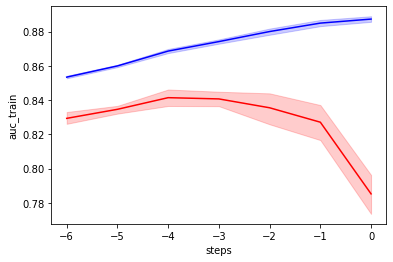

In [67]:
# from the analysis we see the best best average performance with lowest deviation comes from augment the dataset
# with 4 more months
sns.lineplot(x='steps',y='auc_train',data=results_list,color='blue')
sns.lineplot(x='steps',y='auc_valid',data=results_list,color='red')
plt.show()


In [79]:
results_list=results_list.groupby('steps').agg(['mean','std'])
results_list

auc_train           auc_valid           accuracy_train            \
           mean       std      mean       std           mean       std   
steps                                                                    
-6     0.853396  0.001244  0.829395  0.006068       0.761993  0.001787   
-5     0.859953  0.001166  0.834658  0.003919       0.766717  0.002037   
-4     0.868661  0.002012  0.841491  0.008431       0.777027  0.004049   
-3     0.874225  0.002096  0.840758  0.006861       0.782332  0.002861   
-2     0.880107  0.003107  0.835750  0.015921       0.788405  0.004525   
-1     0.885033  0.003056  0.827375  0.017038       0.791997  0.005462   

      accuracy_valid            f1_train            f1_valid            \
                mean       std      mean       std      mean       std   
steps                                                                    
-6          0.742327  0.006290  0.680337  0.002300  0.652975  0.009117   
-5          0.745877  0.008696  0.686275  0.002590  0.659200  0.008772   
-4          0.754877  0.006462  0.698978  0.004851  0.668725  0.012109   
-3          0.757582  0.004607  0.706003  0.003266  0.670759  0.004245   
-2          0.751117  0.015821  0.713914  0.005239  0.661884  0.022806   
-1          0.743751  0.016512  0.718126  0.006755  0.652903  0.019345   

      recall_train           recall_valid           precision_train            \
              mean       std         mean       std            mean       std   
steps                                                                           
-6        0.805628  0.005181     0.771215  0.015791        0.588786  0.002439   
-5        0.811383  0.003842     0.781406  0.013119        0.594599  0.002571   
-4        0.822551  0.004655     0.786721  0.028467        0.607692  0.005174   
-3        0.832762  0.002820     0.786846  0.011859        0.612741  0.003818   
-2        0.841633  0.004829     0.776964  0.032209        0.619866  0.006062   
-1        0.849804  0.007448     0.772678  0.023747        0.621800  0.007077   

      precision_valid            
                 mean       std  
steps                            
-6           0.566241  0.007397  
-5           0.570203  0.011435  
-4           0.581806  0.007642  
-3           0.584653  0.007139  
-2           0.576664  0.019049  
-1           0.565557  0.020832

In [80]:
results_list.columns = ['_'.join(c) for c in results_list.columns]

In [81]:
results_list.sort_values(by='auc_valid_mean',ascending=False,inplace=True)


In [82]:
results_list

,auc_train_mean,auc_train_std,auc_valid_mean,auc_valid_std,accuracy_train_mean,accuracy_train_std,accuracy_valid_mean,accuracy_valid_std,f1_train_mean,f1_train_std,f1_valid_mean,f1_valid_std,recall_train_mean,recall_train_std,recall_valid_mean,recall_valid_std,precision_train_mean,precision_train_std,precision_valid_mean,precision_valid_std
steps,,,,,,,,,,,,,,,,,,,,
-4,0.868661,0.002012,0.841491,0.008431,0.777027,0.004049,0.754877,0.006462,0.698978,0.004851,0.668725,0.012109,0.822551,0.004655,0.786721,0.028467,0.607692,0.005174,0.581806,0.007642
-3,0.874225,0.002096,0.840758,0.006861,0.782332,0.002861,0.757582,0.004607,0.706003,0.003266,0.670759,0.004245,0.832762,0.002820,0.786846,0.011859,0.612741,0.003818,0.584653,0.007139
-2,0.880107,0.003107,0.835750,0.015921,0.788405,0.004525,0.751117,0.015821,0.713914,0.005239,0.661884,0.022806,0.841633,0.004829,0.776964,0.032209,0.619866,0.006062,0.576664,0.019049
-5,0.859953,0.001166,0.834658,0.003919,0.766717,0.002037,0.745877,0.008696,0.686275,0.002590,0.659200,0.008772,0.811383,0.003842,0.781406,0.013119,0.594599,0.002571,0.570203,0.011435
-6,0.853396,0.001244,0.829395,0.006068,0.761993,0.001787,0.742327,0.006290,0.680337,0.002300,0.652975,0.009117,0.805628,0.005181,0.771215,0.015791,0.588786,0.002439,0.566241,0.007397
-1,0.885033,0.003056,0.827375,0.017038,0.791997,0.005462,0.743751,0.016512,0.718126,0.006755,0.652903,0.019345,0.849804,0.007448,0.772678,0.023747,0.621800,0.007077,0.565557,0.020832


In [83]:
results_list['auc_valid_to_train_mean'] = results_list.auc_valid_mean**2/results_list.auc_train_mean

In [84]:
results_list

,auc_train_mean,auc_train_std,auc_valid_mean,auc_valid_std,accuracy_train_mean,accuracy_train_std,accuracy_valid_mean,accuracy_valid_std,f1_train_mean,f1_train_std,f1_valid_mean,f1_valid_std,recall_train_mean,recall_train_std,recall_valid_mean,recall_valid_std,precision_train_mean,precision_train_std,precision_valid_mean,precision_valid_std,auc_valid_to_train_mean
steps,,,,,,,,,,,,,,,,,,,,,
-4,0.868661,0.002012,0.841491,0.008431,0.777027,0.004049,0.754877,0.006462,0.698978,0.004851,0.668725,0.012109,0.822551,0.004655,0.786721,0.028467,0.607692,0.005174,0.581806,0.007642,0.815171
-3,0.874225,0.002096,0.840758,0.006861,0.782332,0.002861,0.757582,0.004607,0.706003,0.003266,0.670759,0.004245,0.832762,0.002820,0.786846,0.011859,0.612741,0.003818,0.584653,0.007139,0.808573
-2,0.880107,0.003107,0.835750,0.015921,0.788405,0.004525,0.751117,0.015821,0.713914,0.005239,0.661884,0.022806,0.841633,0.004829,0.776964,0.032209,0.619866,0.006062,0.576664,0.019049,0.793629
-5,0.859953,0.001166,0.834658,0.003919,0.766717,0.002037,0.745877,0.008696,0.686275,0.002590,0.659200,0.008772,0.811383,0.003842,0.781406,0.013119,0.594599,0.002571,0.570203,0.011435,0.810107
-6,0.853396,0.001244,0.829395,0.006068,0.761993,0.001787,0.742327,0.006290,0.680337,0.002300,0.652975,0.009117,0.805628,0.005181,0.771215,0.015791,0.588786,0.002439,0.566241,0.007397,0.806069
-1,0.885033,0.003056,0.827375,0.017038,0.791997,0.005462,0.743751,0.016512,0.718126,0.006755,0.652903,0.019345,0.849804,0.007448,0.772678,0.023747,0.621800,0.007077,0.565557,0.020832,0.773472


In [85]:
results_list.sort_values(by='auc_valid_to_train_mean',ascending=False,inplace=True)
results_list

,auc_train_mean,auc_train_std,auc_valid_mean,auc_valid_std,accuracy_train_mean,accuracy_train_std,accuracy_valid_mean,accuracy_valid_std,f1_train_mean,f1_train_std,f1_valid_mean,f1_valid_std,recall_train_mean,recall_train_std,recall_valid_mean,recall_valid_std,precision_train_mean,precision_train_std,precision_valid_mean,precision_valid_std,auc_valid_to_train_mean
steps,,,,,,,,,,,,,,,,,,,,,
-4,0.868661,0.002012,0.841491,0.008431,0.777027,0.004049,0.754877,0.006462,0.698978,0.004851,0.668725,0.012109,0.822551,0.004655,0.786721,0.028467,0.607692,0.005174,0.581806,0.007642,0.815171
-5,0.859953,0.001166,0.834658,0.003919,0.766717,0.002037,0.745877,0.008696,0.686275,0.002590,0.659200,0.008772,0.811383,0.003842,0.781406,0.013119,0.594599,0.002571,0.570203,0.011435,0.810107
-3,0.874225,0.002096,0.840758,0.006861,0.782332,0.002861,0.757582,0.004607,0.706003,0.003266,0.670759,0.004245,0.832762,0.002820,0.786846,0.011859,0.612741,0.003818,0.584653,0.007139,0.808573
-6,0.853396,0.001244,0.829395,0.006068,0.761993,0.001787,0.742327,0.006290,0.680337,0.002300,0.652975,0.009117,0.805628,0.005181,0.771215,0.015791,0.588786,0.002439,0.566241,0.007397,0.806069
-2,0.880107,0.003107,0.835750,0.015921,0.788405,0.004525,0.751117,0.015821,0.713914,0.005239,0.661884,0.022806,0.841633,0.004829,0.776964,0.032209,0.619866,0.006062,0.576664,0.019049,0.793629
-1,0.885033,0.003056,0.827375,0.017038,0.791997,0.005462,0.743751,0.016512,0.718126,0.006755,0.652903,0.019345,0.849804,0.007448,0.772678,0.023747,0.621800,0.007077,0.565557,0.020832,0.773472


In [86]:
step = results_list.index[0]
temp_data = augmented_dataset.loc[augmented_dataset.step_global >= step,:].copy()
training_set = pd.concat([transaction_train_pivot,temp_data])
training_set.reset_index(inplace=True)
training_set.fillna(0,inplace=True)
training_set.shape
    

(11382, 49665)

In [87]:
# now that we have more data, we should assess again the RandomForest and other algorithms
cv_indices = list(cvsplitter.split(training_set.customer_id_mskd,training_set.target))

In [88]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing random forest, class_weight = 'balanced' because the data is unbalanced
logit = xgb.XGBRFClassifier(n_jobs=-1,
                            reg_lambda=1,n_estimators=100,
                            colsample_bytree=2/3,
                            colsample_bylevel=2/3,
                            colsample_bynode =2/3 ,
                            max_depth=4,
                            tree_method='hist')
model = make_pipeline(scaler,logit)

results = run_cross_validation(training_set, features0, 'target', cv_indices, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)


(auc_train          0.792581
 auc_valid          0.749126
 accuracy_train     0.701920
 accuracy_valid     0.697593
 f1_train           0.126588
 f1_valid           0.105285
 recall_train       0.068781
 recall_valid       0.056675
 precision_train    0.815107
 precision_valid    0.770653
 dtype: float64,
 auc_train          0.004889
 auc_valid          0.007482
 accuracy_train     0.002056
 accuracy_valid     0.002102
 f1_train           0.017319
 f1_valid           0.016576
 recall_train       0.010317
 recall_valid       0.009733
 precision_train    0.025609
 precision_valid    0.052942
 dtype: float64)

In [89]:
# Random forest has a high precision, while Logistic Regression has a high recall
# combining both might be a good alternative
# before we could optimize random forest parameters since they are very sensitive to high parameter selection

In [90]:
import optuna

def random_forest_trial(data,trial):
    # will scale feature from (0,1) to increase speed
    scaler = MinMaxScaler()
    
    #cv object     
    cv_indices = list(cvsplitter.split(data.customer_id_mskd,data.target))
    # testing random forest, class_weight = 'balanced' because the data is unbalanced
    #parameters
    
    params = {
        'objective':'binary:logistic',
        'n_jobs':-1,
        'n_estimators':100,
        'tree_method':'hist',
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.05,1,0.05),
        'colsample_bylevel':trial.suggest_discrete_uniform('colsample_bylevel',0.05,1,0.05),
        'colsample_bynode':trial.suggest_discrete_uniform('colsample_bynode',0.05,1,0.05),
        'max_depth':trial.suggest_int('max_depth',3,4),
        'gamma':trial.suggest_uniform('gamma',0,10),
        'min_child_weight':trial.suggest_uniform('min_child_weight',0,50),
        'subsample':trial.suggest_discrete_uniform('subsample',0.625,1,0.025),
        'lambda':trial.suggest_discrete_uniform('lambda',0,5,0.005),
        'alpha':trial.suggest_discrete_uniform('alpha',0,5,0.005),
        
       
        
        
    }
    
    
    logit = xgb.XGBRFClassifier(**params)
    
    model = make_pipeline(scaler,logit)

    results = run_cross_validation(data, features0, 'target', cv_indices, model)
    # print(results)

    mean_results = np.mean(results,axis=0)
    print(mean_results)
    #adjusted valid auc
    # going to penalize for large discrepancies     
    loss= mean_results['auc_valid']**2/mean_results['auc_train']
    
    return -loss



In [91]:
%%time
np.random.seed(123)
study = optuna.create_study(direction='minimize')  
study.optimize(partial(random_forest_trial, training_set),n_trials = 20 )
    


auc_train          0.677379
auc_valid          0.658382
accuracy_train     0.686918
accuracy_valid     0.686479
f1_train           0.016491
f1_valid           0.016478
recall_train       0.008794
recall_valid       0.008935
precision_train    0.145722
precision_valid    0.125098
dtype: float64


[I 2021-02-14 12:24:13,011] Finished trial#0 resulted in value: -0.6399179693106655. Current best value is -0.6399179693106655 with parameters: {'colsample_bytree': 0.3, 'colsample_bylevel': 0.35000000000000003, 'colsample_bynode': 0.15000000000000002, 'max_depth': 3, 'gamma': 6.621967972090292, 'min_child_weight': 24.4311646431143, 'subsample': 0.925, 'lambda': 1.78, 'alpha': 3.0100000000000002}.



auc_train          0.661828
auc_valid          0.644410
accuracy_train     0.693046
accuracy_valid     0.691926
f1_train           0.064903
f1_valid           0.059484
recall_train       0.034128
recall_valid       0.031271
precision_train    0.804486
precision_valid    0.773566
dtype: float64


[I 2021-02-14 12:30:32,048] Finished trial#1 resulted in value: -0.6274506908807931. Current best value is -0.6399179693106655 with parameters: {'colsample_bytree': 0.3, 'colsample_bylevel': 0.35000000000000003, 'colsample_bynode': 0.15000000000000002, 'max_depth': 3, 'gamma': 6.621967972090292, 'min_child_weight': 24.4311646431143, 'subsample': 0.925, 'lambda': 1.78, 'alpha': 3.0100000000000002}.



auc_train          0.715610
auc_valid          0.684544
accuracy_train     0.698109
accuracy_valid     0.694122
f1_train           0.095539
f1_valid           0.078937
recall_train       0.050740
recall_valid       0.041737
precision_train    0.838017
precision_valid    0.764457
dtype: float64


[I 2021-02-14 12:36:37,897] Finished trial#2 resulted in value: -0.654826741734984. Current best value is -0.654826741734984 with parameters: {'colsample_bytree': 0.25, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.55, 'max_depth': 4, 'gamma': 2.2953728531536735, 'min_child_weight': 23.421791691077182, 'subsample': 0.775, 'lambda': 2.71, 'alpha': 4.8}.



auc_train          0.710354
auc_valid          0.686325
accuracy_train     0.692310
accuracy_valid     0.690388
f1_train           0.054687
f1_valid           0.045910
recall_train       0.028337
recall_valid       0.023729
precision_train    0.826763
precision_valid    0.767581
dtype: float64


[I 2021-02-14 12:42:42,309] Finished trial#3 resulted in value: -0.6631074457886792. Current best value is -0.6631074457886792 with parameters: {'colsample_bytree': 0.25, 'colsample_bylevel': 0.2, 'colsample_bynode': 0.6500000000000001, 'max_depth': 4, 'gamma': 8.132960986979738, 'min_child_weight': 46.067013769188904, 'subsample': 0.825, 'lambda': 0.755, 'alpha': 0.62}.



auc_train          0.754796
auc_valid          0.717090
accuracy_train     0.717163
accuracy_valid     0.708487
f1_train           0.222892
f1_valid           0.193319
recall_train       0.130271
recall_valid       0.112224
precision_train    0.827403
precision_valid    0.754604
dtype: float64


[I 2021-02-14 12:52:04,460] Finished trial#4 resulted in value: -0.6812683715751601. Current best value is -0.6812683715751601 with parameters: {'colsample_bytree': 0.25, 'colsample_bylevel': 0.25, 'colsample_bynode': 0.6500000000000001, 'max_depth': 5, 'gamma': 7.52043113935677, 'min_child_weight': 18.45136252859114, 'subsample': 1.0, 'lambda': 3.8000000000000003, 'alpha': 2.775}.



auc_train          0.771057
auc_valid          0.730322
accuracy_train     0.700448
accuracy_valid     0.696714
f1_train           0.116372
f1_valid           0.099073
recall_train       0.062744
recall_valid       0.053044
precision_train    0.812102
precision_valid    0.763829
dtype: float64


[I 2021-02-14 12:58:59,075] Finished trial#5 resulted in value: -0.6917386344323635. Current best value is -0.6917386344323635 with parameters: {'colsample_bytree': 0.5, 'colsample_bylevel': 0.25, 'colsample_bynode': 0.9500000000000001, 'max_depth': 4, 'gamma': 0.32501513724244147, 'min_child_weight': 13.686142002893288, 'subsample': 0.85, 'lambda': 1.52, 'alpha': 4.23}.



auc_train          0.623172
auc_valid          0.615247
accuracy_train     0.685293
accuracy_valid     0.685293
f1_train           0.000000
f1_valid           0.000000
recall_train       0.000000
recall_valid       0.000000
precision_train    0.000000
precision_valid    0.000000
dtype: float64


[I 2021-02-14 13:04:24,483] Finished trial#6 resulted in value: -0.607422668861508. Current best value is -0.6917386344323635 with parameters: {'colsample_bytree': 0.5, 'colsample_bylevel': 0.25, 'colsample_bynode': 0.9500000000000001, 'max_depth': 4, 'gamma': 0.32501513724244147, 'min_child_weight': 13.686142002893288, 'subsample': 0.85, 'lambda': 1.52, 'alpha': 4.23}.



auc_train          0.835753
auc_valid          0.774881
accuracy_train     0.732055
accuracy_valid     0.713671
f1_train           0.276904
f1_valid           0.202657
recall_train       0.163769
recall_valid       0.116000
precision_train    0.916263
precision_valid    0.820636
dtype: float64


[I 2021-02-14 13:10:55,000] Finished trial#7 resulted in value: -0.7184431311890975. Current best value is -0.7184431311890975 with parameters: {'colsample_bytree': 0.2, 'colsample_bylevel': 0.25, 'colsample_bynode': 0.55, 'max_depth': 5, 'gamma': 0.9634157065841842, 'min_child_weight': 0.42548077784707594, 'subsample': 0.675, 'lambda': 0.73, 'alpha': 4.065}.



auc_train          0.701496
auc_valid          0.675401
accuracy_train     0.706807
accuracy_valid     0.700316
f1_train           0.175343
f1_valid           0.154657
recall_train       0.099771
recall_valid       0.087934
precision_train    0.770706
precision_valid    0.692824
dtype: float64


[I 2021-02-14 13:17:34,656] Finished trial#8 resulted in value: -0.65027643373968. Current best value is -0.7184431311890975 with parameters: {'colsample_bytree': 0.2, 'colsample_bylevel': 0.25, 'colsample_bynode': 0.55, 'max_depth': 5, 'gamma': 0.9634157065841842, 'min_child_weight': 0.42548077784707594, 'subsample': 0.675, 'lambda': 0.73, 'alpha': 4.065}.



auc_train          0.633597
auc_valid          0.622029
accuracy_train     0.685293
accuracy_valid     0.685293
f1_train           0.000000
f1_valid           0.000000
recall_train       0.000000
recall_valid       0.000000
precision_train    0.000000
precision_valid    0.000000
dtype: float64


[I 2021-02-14 13:22:24,321] Finished trial#9 resulted in value: -0.6106726292849095. Current best value is -0.7184431311890975 with parameters: {'colsample_bytree': 0.2, 'colsample_bylevel': 0.25, 'colsample_bynode': 0.55, 'max_depth': 5, 'gamma': 0.9634157065841842, 'min_child_weight': 0.42548077784707594, 'subsample': 0.675, 'lambda': 0.73, 'alpha': 4.065}.



auc_train          0.813079
auc_valid          0.767459
accuracy_train     0.730671
accuracy_valid     0.717800
f1_train           0.303556
f1_valid           0.264578
recall_train       0.186768
recall_valid       0.161922
precision_train    0.814651
precision_valid    0.734983
dtype: float64


[I 2021-02-14 13:31:39,312] Finished trial#10 resulted in value: -0.7243994931301921. Current best value is -0.7243994931301921 with parameters: {'colsample_bytree': 1.0, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 0.9500000000000001, 'max_depth': 5, 'gamma': 3.7016040923111415, 'min_child_weight': 3.8430915243437984, 'subsample': 0.875, 'lambda': 4.855, 'alpha': 1.2550000000000001}.



auc_train          0.759098
auc_valid          0.716505
accuracy_train     0.721380
accuracy_valid     0.707696
f1_train           0.283584
f1_valid           0.244705
recall_train       0.175950
recall_valid       0.151031
precision_train    0.746227
precision_valid    0.660922
dtype: float64


[I 2021-02-14 13:41:50,537] Finished trial#11 resulted in value: -0.676302127040742. Current best value is -0.7243994931301921 with parameters: {'colsample_bytree': 1.0, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 0.9500000000000001, 'max_depth': 5, 'gamma': 3.7016040923111415, 'min_child_weight': 3.8430915243437984, 'subsample': 0.875, 'lambda': 4.855, 'alpha': 1.2550000000000001}.



auc_train          0.842074
auc_valid          0.788169
accuracy_train     0.731693
accuracy_valid     0.716878
f1_train           0.284305
f1_valid           0.227059
recall_train       0.169458
recall_valid       0.132331
precision_train    0.884719
precision_valid    0.804992
dtype: float64


[I 2021-02-14 13:51:06,086] Finished trial#12 resulted in value: -0.7377144387053496. Current best value is -0.7377144387053496 with parameters: {'colsample_bytree': 0.8500000000000001, 'colsample_bylevel': 0.7000000000000001, 'colsample_bynode': 0.9000000000000001, 'max_depth': 5, 'gamma': 0.1840365311132054, 'min_child_weight': 0.18814107108132871, 'subsample': 1.0, 'lambda': 4.965, 'alpha': 1.795}.



auc_train          0.783577
auc_valid          0.744215
accuracy_train     0.720381
accuracy_valid     0.711870
f1_train           0.246798
f1_valid           0.218138
recall_train       0.146148
recall_valid       0.128419
precision_train    0.809517
precision_valid    0.744643
dtype: float64


[I 2021-02-14 13:58:18,221] Finished trial#13 resulted in value: -0.7068303336031385. Current best value is -0.7377144387053496 with parameters: {'colsample_bytree': 0.8500000000000001, 'colsample_bylevel': 0.7000000000000001, 'colsample_bynode': 0.9000000000000001, 'max_depth': 5, 'gamma': 0.1840365311132054, 'min_child_weight': 0.18814107108132871, 'subsample': 1.0, 'lambda': 4.965, 'alpha': 1.795}.



auc_train          0.850203
auc_valid          0.794519
accuracy_train     0.746332
accuracy_valid     0.725708
f1_train           0.364065
f1_valid           0.298523
recall_train       0.231504
recall_valid       0.185935
precision_train    0.861465
precision_valid    0.766466
dtype: float64


[I 2021-02-14 14:06:02,986] Finished trial#14 resulted in value: -0.7424819251091294. Current best value is -0.7424819251091294 with parameters: {'colsample_bytree': 0.8500000000000001, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8500000000000001, 'max_depth': 5, 'gamma': 1.7790432974779082, 'min_child_weight': 1.3181219769152441, 'subsample': 0.625, 'lambda': 3.86, 'alpha': 2.0300000000000002}.



auc_train          0.850997
auc_valid          0.794871
accuracy_train     0.740885
accuracy_valid     0.721710
f1_train           0.328617
f1_valid           0.263982
recall_train       0.201703
recall_valid       0.158992
precision_train    0.889447
precision_valid    0.785960
dtype: float64


[I 2021-02-14 14:15:48,034] Finished trial#15 resulted in value: -0.7424462563823285. Current best value is -0.7424819251091294 with parameters: {'colsample_bytree': 0.8500000000000001, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8500000000000001, 'max_depth': 5, 'gamma': 1.7790432974779082, 'min_child_weight': 1.3181219769152441, 'subsample': 0.625, 'lambda': 3.86, 'alpha': 2.0300000000000002}.



auc_train          0.819289
auc_valid          0.767072
accuracy_train     0.719228
accuracy_valid     0.709936
f1_train           0.223950
f1_valid           0.186804
recall_train       0.128909
recall_valid       0.106084
precision_train    0.860407
precision_valid    0.793018
dtype: float64


[I 2021-02-14 14:24:36,938] Finished trial#16 resulted in value: -0.7181822826944116. Current best value is -0.7424819251091294 with parameters: {'colsample_bytree': 0.8500000000000001, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8500000000000001, 'max_depth': 5, 'gamma': 1.7790432974779082, 'min_child_weight': 1.3181219769152441, 'subsample': 0.625, 'lambda': 3.86, 'alpha': 2.0300000000000002}.



auc_train          0.844402
auc_valid          0.786181
accuracy_train     0.721007
accuracy_valid     0.708575
f1_train           0.230747
f1_valid           0.180987
recall_train       0.133096
recall_valid       0.102459
precision_train    0.872183
precision_valid    0.786025
dtype: float64


[I 2021-02-14 14:33:17,145] Finished trial#17 resulted in value: -0.7319751404624966. Current best value is -0.7424819251091294 with parameters: {'colsample_bytree': 0.8500000000000001, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8500000000000001, 'max_depth': 5, 'gamma': 1.7790432974779082, 'min_child_weight': 1.3181219769152441, 'subsample': 0.625, 'lambda': 3.86, 'alpha': 2.0300000000000002}.



auc_train          0.863567
auc_valid          0.803118
accuracy_train     0.731660
accuracy_valid     0.714066
f1_train           0.278461
f1_valid           0.206731
recall_train       0.164852
recall_valid       0.118649
precision_train    0.905115
precision_valid    0.816190
dtype: float64


[I 2021-02-14 14:41:40,026] Finished trial#18 resulted in value: -0.7468994078848465. Current best value is -0.7468994078848465 with parameters: {'colsample_bytree': 0.6500000000000001, 'colsample_bylevel': 0.6000000000000001, 'colsample_bynode': 0.8, 'max_depth': 5, 'gamma': 1.6948180145086138, 'min_child_weight': 0.06654710126891916, 'subsample': 0.9750000000000001, 'lambda': 3.18, 'alpha': 2.195}.



auc_train          0.756723
auc_valid          0.722639
accuracy_train     0.701678
accuracy_valid     0.697724
f1_train           0.131903
f1_valid           0.112762
recall_train       0.072132
recall_valid       0.061138
precision_train    0.785826
precision_valid    0.747275
dtype: float64


[I 2021-02-14 14:48:26,080] Finished trial#19 resulted in value: -0.6900909674098527. Current best value is -0.7468994078848465 with parameters: {'colsample_bytree': 0.6500000000000001, 'colsample_bylevel': 0.6000000000000001, 'colsample_bynode': 0.8, 'max_depth': 5, 'gamma': 1.6948180145086138, 'min_child_weight': 0.06654710126891916, 'subsample': 0.9750000000000001, 'lambda': 3.18, 'alpha': 2.195}.


Wall time: 2h 29min 39s


In [92]:
params = study.best_params

In [93]:
params.update( {'objective':'binary:logistic',
        'n_jobs':-1,
        'n_estimators':200,
        'tree_method':'hist'})

In [94]:
params

{'colsample_bytree': 0.6500000000000001,
 'colsample_bylevel': 0.6000000000000001,
 'colsample_bynode': 0.8,
 'max_depth': 5,
 'gamma': 1.6948180145086138,
 'min_child_weight': 0.06654710126891916,
 'subsample': 0.9750000000000001,
 'lambda': 3.18,
 'alpha': 2.195,
 'objective': 'binary:logistic',
 'n_jobs': -1,
 'n_estimators': 200,
 'tree_method': 'hist'}

In [69]:
params = {'colsample_bytree': 0.6500000000000001,
 'colsample_bylevel': 0.6000000000000001,
 'colsample_bynode': 0.8,
 'max_depth': 4,
 'gamma': 1.6948180145086138,
 'min_child_weight': 0.06654710126891916,
 'subsample': 0.9750000000000001,
 'lambda': 3.18,
 'alpha': 2.195,
 'objective': 'binary:logistic',
 'n_jobs': -1,
 'n_estimators': 200,
 'tree_method': 'hist'}

In [70]:
# will scale feature from (0,1) to increase speed
scaler = MinMaxScaler()

# testing random forest, class_weight = 'balanced' because the data is unbalanced
logit = xgb.XGBRFClassifier(**params)
model = make_pipeline(scaler,logit)

results = run_cross_validation(training_set, features0, 'target', cv_indices, model)
# print(results)

np.mean(results,axis=0),np.std(results,axis=0)


(auc_train          0.783195
 auc_valid          0.747140
 accuracy_train     0.706233
 accuracy_valid     0.700500
 f1_train           0.151441
 f1_valid           0.128410
 recall_train       0.083533
 recall_valid       0.070235
 precision_train    0.823733
 precision_valid    0.756419
 dtype: float64,
 auc_train          0.004534
 auc_valid          0.007556
 accuracy_train     0.002745
 accuracy_valid     0.002188
 f1_train           0.018429
 f1_valid           0.011717
 recall_train       0.011221
 recall_valid       0.006936
 precision_train    0.016801
 precision_valid    0.040404
 dtype: float64)

In [124]:
xgbboost_feature_imp = pd.DataFrame()
xgbboost_feature_imp['feature'] = features0
xgbboost_feature_imp['importance'] = logit.feature_importances_
xgbboost_feature_imp.to_csv('importance_xgboost.csv',index=False)



In [72]:
# lets try to combine the RF classifier with logistic regression
# list to store results
predictions=[]

# cross validation
for i,(trainidx,validx) in enumerate(tqdm.tqdm_notebook(cv_indices),1):
    
    
    # will scale feature from (0,1) to increase speed
    scaler = MinMaxScaler()
    # testing logistic regression, class_weight = 'balanced' because the data is unbalanced
    logit = LogisticRegression(class_weight='balanced',max_iter=1_000_000)
    model = make_pipeline(scaler,logit)
    
    train = training_set.loc[trainidx,:].copy()
    valid = training_set.loc[validx,:].copy()
    
    model.fit(train[selected_features],train['target'])
    
    #dataframe for training to store results     
    prediction_train = pd.DataFrame()
    #client data     
    prediction_train['customer_id_mskd'] = train.customer_id_mskd
    
    # steps deleted    
    prediction_train['steps'] = train.step_global.fillna(0)
    
    #target     
    prediction_train['target'] = train.target
    #rating     
    prediction_train['rating'] = train.rating
    #probability of being high risk calculated using logistic regression     
    prediction_train['logit_proba'] = model.predict_proba(train[selected_features])[:,1]
    #flagging if it is train or test     
    prediction_train['train_test'] = 'train'
    
    #same for test data     
    prediction_test = pd.DataFrame()
    prediction_test['customer_id_mskd'] = valid.customer_id_mskd
    prediction_test['steps'] = valid.step_global.fillna(0)
    prediction_test['target'] = valid.target
    prediction_test['rating'] = valid.rating
    prediction_test['logit_proba'] = model.predict_proba(valid[selected_features])[:,1]
    prediction_test['train_test'] = 'test'
    
    
    #random forest     
    scaler = MinMaxScaler()
    logit = xgb.XGBRFClassifier(**params)
    model = make_pipeline(scaler,logit)
    model.fit(train[features0],train['target'])
    prediction_train['xgbrf_proba'] = model.predict_proba(train[features0])[:,1]
    prediction_test['xgbrf_proba'] = model.predict_proba(valid[features0])[:,1]

    pred = pd.concat([prediction_train,prediction_test])
    pred['fold'] = i
    predictions.append(pred)


In [73]:
predictions=pd.concat(predictions)
predictions.head()

,customer_id_mskd,steps,target,rating,logit_proba,train_test,xgbrf_proba,fold
0,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,0.0,0,2,0.485560,train,0.404780,1
3,003d9eeb40160ef70a08e3a381d14b99193fdb8b548a60...,0.0,0,2,0.083318,train,0.357186,1
5,0069e6aacc6786ab7c3ef310f2ede7e30fed82a1a44e9f...,0.0,0,2,0.140416,train,0.323244,1
6,00776c986c016e0c57f9dc643644bfc5e6ec52820998b4...,0.0,0,2,0.030555,train,0.243116,1
7,007e96634703a956e7f9705f4524ecf8ae9a9621b01953...,0.0,0,2,0.028980,train,0.174165,1


In [74]:
predictions.to_csv('predictions_medium.csv',index=False)

In [75]:
# now we will combine the probability weightage for each model using a simple loop

# scope of wieghts
logit_weight = np.linspace(0,1,1000)
metrics_calculation=[]
train_target =  predictions.loc[predictions.train_test=='train',:].copy()
train_target['auc_logit'] = roc_auc_score(train_target.target,train_target.logit_proba)
train_target['auc_xgbrf'] = roc_auc_score(train_target.target,train_target.logit_proba)

test_target =  predictions.loc[predictions.train_test=='test',:].copy()
test_target['auc_logit'] = roc_auc_score(test_target.target,test_target.logit_proba)
test_target['auc_xgbrf'] = roc_auc_score(test_target.target,test_target.logit_proba)


for weight in  logit_weight:
    
    #new probability = logistic regression x weight + random forest x (1-weight)     
    new_train_proba = train_target.logit_proba*weight + train_target.xgbrf_proba*(1-weight)
    new_test_proba = test_target.logit_proba*weight + test_target.xgbrf_proba*(1-weight)
    
    #calculate the auc     
    new_auc_train =  roc_auc_score(train_target.target,new_train_proba)
    new_auc_test =  roc_auc_score(test_target.target,new_test_proba)
    
    #calculate the recall
    new_recall_train = recall_score(train_target.target,(np.round(new_train_proba,2) >= 0.50).astype(int))
    new_recall_test = recall_score(test_target.target,(np.round(new_test_proba,2) >= 0.50).astype(int))
    
    #calculate the precision
    new_precision_train = precision_score(train_target.target,(np.round(new_train_proba,2) >= 0.50).astype(int))
    new_precision_test = precision_score(test_target.target,(np.round(new_test_proba,2) >= 0.50).astype(int))

    #calculate the f1 score
    new_f1_train = f1_score(train_target.target,(np.round(new_train_proba,2) >= 0.50).astype(int))
    new_f1_test = f1_score(test_target.target,(np.round(new_test_proba,2) >= 0.50).astype(int))
    
    #append all results     
    metrics_calculation.append([weight,
                                new_auc_train,
                                new_auc_test,
                                new_recall_train,
                                new_recall_test,
                                new_precision_train,
                                new_precision_test,
                                new_f1_train,
                                new_f1_test])
    
    


In [76]:
metrics_calculation_df = pd.DataFrame(metrics_calculation, 
                                      columns = ['weight', 
                                                 'auc_train',
                                                 'auc_test', 
                                                 'recall_train',
                                                 'recall_test', 
                                                 'precision_train',
                                                 'precision_test', 
                                                 'f1_train',
                                                 'f1_test'])
metrics_calculation_df.to_csv('metrics_calculation_df.csv',index=False)

In [77]:
metrics_calculation=np.array(metrics_calculation)

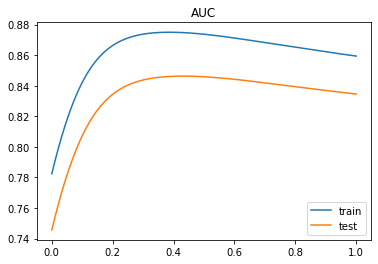

In [78]:
plt.title('AUC')
plt.plot(metrics_calculation[:,0],metrics_calculation[:,1],label='train')
plt.plot(metrics_calculation[:,0],metrics_calculation[:,2],label='test')
plt.legend(loc="lower right")

plt.show()

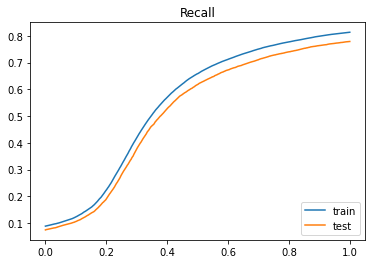

In [79]:
plt.title('Recall')
plt.plot(metrics_calculation[:,0],metrics_calculation[:,3],label='train')
plt.plot(metrics_calculation[:,0],metrics_calculation[:,4],label='test')
plt.legend(loc="lower right")

plt.show()


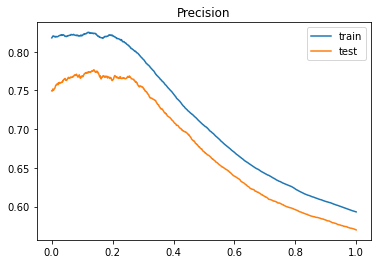

In [80]:
plt.title('Precision')
plt.plot(metrics_calculation[:,0],metrics_calculation[:,5],label='train')
plt.plot(metrics_calculation[:,0],metrics_calculation[:,6],label='test')
plt.legend(loc="upper right")

plt.show()



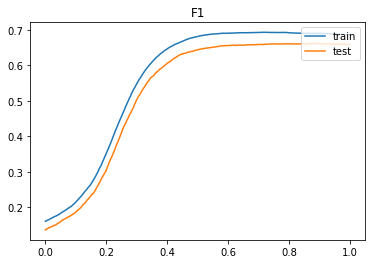

In [81]:
plt.title('F1')
plt.plot(metrics_calculation[:,0],metrics_calculation[:,7],label='train')
plt.plot(metrics_calculation[:,0],metrics_calculation[:,8],label='test')
plt.legend(loc="upper right")


plt.show()




In [82]:
final_logit_weight = metrics_calculation[np.argmax(metrics_calculation[:,2])][0]

In [83]:
final_logit_weight

0.43043043043043044

In [84]:
metrics_calculation[np.argmax(metrics_calculation[:,2])]

array([0.43043043, 0.87480782, 0.84631937, 0.60276442, 0.56281355,
       0.73098007, 0.69799093, 0.66070943, 0.6231557 ])

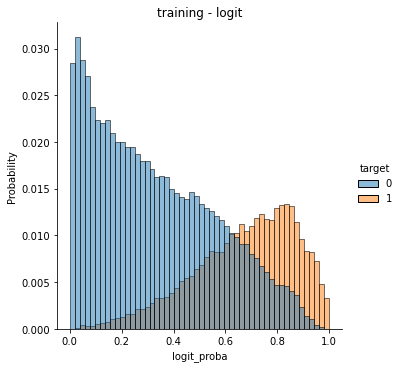

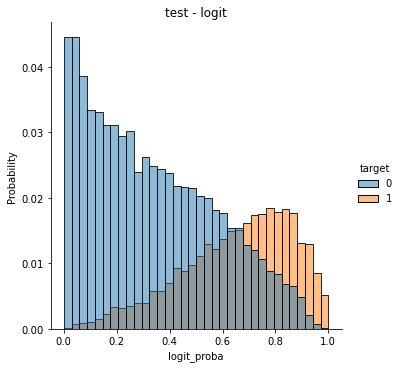

In [85]:
# plotting distribution

f=predictions.train_test=='train'

sns.displot(data=predictions.loc[f,:],x='logit_proba',hue='target',stat='probability')
plt.title('training - logit')

plt.show()

f=predictions.train_test=='test'

sns.displot(data=predictions.loc[f,:],x='logit_proba',hue='target',stat='probability',)
plt.title('test - logit')
plt.show()



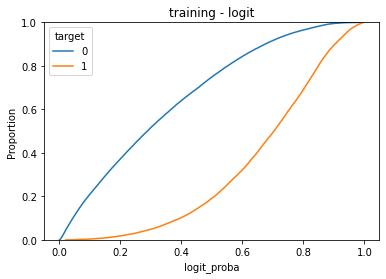

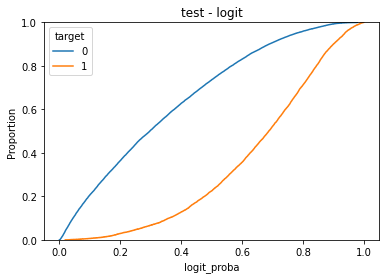

In [86]:
# plotting distribution

f=predictions.train_test=='train'

sns.ecdfplot(data=predictions.loc[f,:],x='logit_proba',hue='target')
plt.title('training - logit')

plt.show()

f=predictions.train_test=='test'

sns.ecdfplot(data=predictions.loc[f,:],x='logit_proba',hue='target')
plt.title('test - logit')
plt.show()



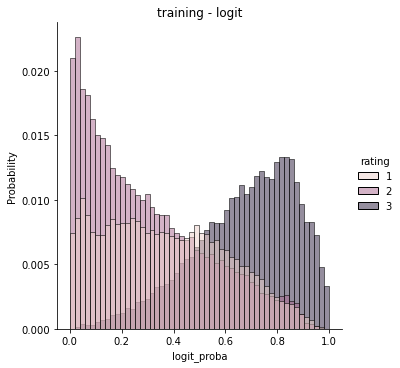

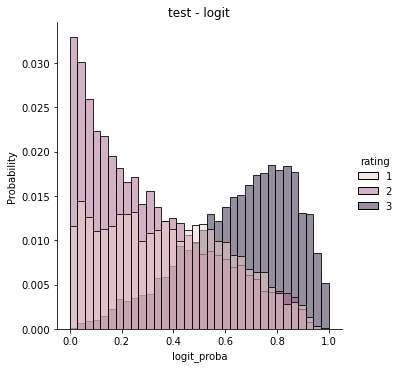

In [87]:
# plotting distribution

f=predictions.train_test=='train'

sns.displot(data=predictions.loc[f,:],x='logit_proba',hue='rating',stat='probability')
plt.title('training - logit')

plt.show()

f=predictions.train_test=='test'

sns.displot(data=predictions.loc[f,:],x='logit_proba',hue='rating',stat='probability',)
plt.title('test - logit')
plt.show()



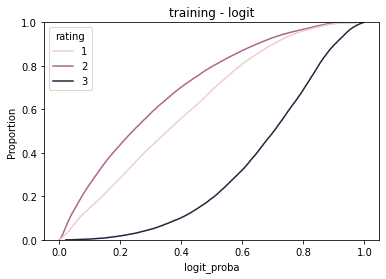

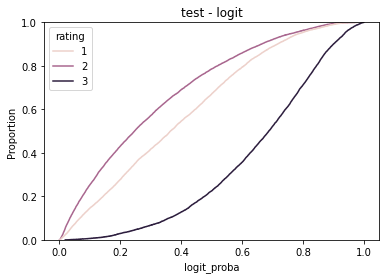

In [88]:
# plotting distribution

f=predictions.train_test=='train'

sns.ecdfplot(data=predictions.loc[f,:],x='logit_proba',hue='rating')
plt.title('training - logit')

plt.show()

f=predictions.train_test=='test'

sns.ecdfplot(data=predictions.loc[f,:],x='logit_proba',hue='rating')
plt.title('test - logit')
plt.show()



In [89]:
final_proba = predictions.logit_proba*final_logit_weight + predictions.xgbrf_proba*(1-final_logit_weight)

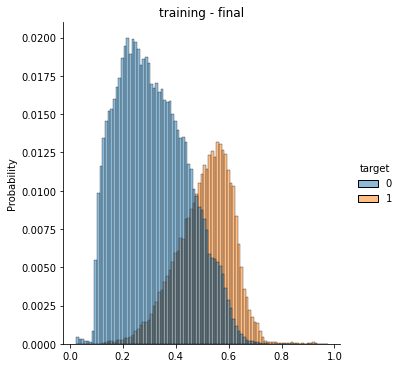

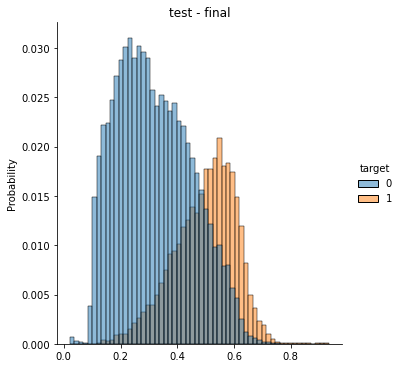

In [90]:
# plotting distribution
# plotting distribution

f=predictions.train_test=='train'

sns.displot(data=predictions.loc[f,:],x=final_proba[f],hue='target',stat='probability')
plt.title('training - final')

plt.show()

f=predictions.train_test=='test'

sns.displot(data=predictions.loc[f,:],x=final_proba[f],hue='target',stat='probability',)
plt.title('test - final')
plt.show()



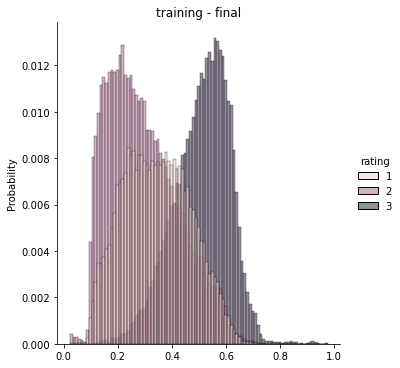

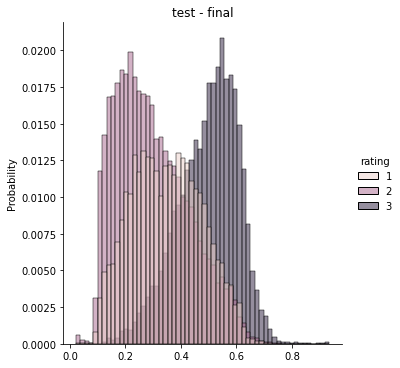

In [91]:
# plotting distribution
# plotting distribution

f=predictions.train_test=='train'

sns.displot(data=predictions.loc[f,:],x=final_proba[f],hue='rating',stat='probability')
plt.title('training - final')

plt.show()

f=predictions.train_test=='test'

sns.displot(data=predictions.loc[f,:],x=final_proba[f],hue='rating',stat='probability',)
plt.title('test - final')
plt.show()



In [92]:
train_target.head()

,customer_id_mskd,steps,target,rating,logit_proba,train_test,xgbrf_proba,fold,auc_logit,auc_xgbrf
0,002b16545bbd16e87c66226dcbe7e0f95b25dccc33d517...,0.0,0,2,0.485560,train,0.404780,1,0.859439,0.859439
3,003d9eeb40160ef70a08e3a381d14b99193fdb8b548a60...,0.0,0,2,0.083318,train,0.357186,1,0.859439,0.859439
5,0069e6aacc6786ab7c3ef310f2ede7e30fed82a1a44e9f...,0.0,0,2,0.140416,train,0.323244,1,0.859439,0.859439
6,00776c986c016e0c57f9dc643644bfc5e6ec52820998b4...,0.0,0,2,0.030555,train,0.243116,1,0.859439,0.859439
7,007e96634703a956e7f9705f4524ecf8ae9a9621b01953...,0.0,0,2,0.028980,train,0.174165,1,0.859439,0.859439


In [95]:
predictions['final_proba'] = predictions.logit_proba*final_logit_weight + predictions.xgbrf_proba*(1-final_logit_weight)

train_target =  predictions.loc[predictions.train_test=='train',:].copy()

test_target =  predictions.loc[predictions.train_test=='test',:].copy()


fpr_logit_train, tpr_logit_train, _ = roc_curve(train_target.target, train_target.logit_proba)
x=pd.DataFrame()
x['fpr']=fpr_logit_train
x['tpr']=tpr_logit_train

x['train_test']='train'
x['model']='logit'
auc_plotting_final = pd.DataFrame()

auc_plotting_final=auc_plotting_final.append(x,ignore_index=True)


fpr_rf_train, tpr_rf_train, _ = roc_curve(train_target.target, train_target.xgbrf_proba)
x=pd.DataFrame()
x['fpr']=fpr_rf_train
x['tpr']=tpr_rf_train
x['train_test']='train'
x['model']='xgb'
auc_plotting_final=auc_plotting_final.append(x,ignore_index=True)


fpr_logit_test, tpr_logit_test, _ = roc_curve(test_target.target, test_target.logit_proba)
x=pd.DataFrame()
x['fpr']=fpr_logit_test
x['tpr']=tpr_logit_test
x['train_test']='test'
x['model']='logit'
auc_plotting_final=auc_plotting_final.append(x,ignore_index=True)



fpr_rf_test, tpr_rf_test, _ = roc_curve(test_target.target, test_target.xgbrf_proba)
x=pd.DataFrame()
x['fpr']=fpr_rf_test
x['tpr']=tpr_rf_test
x['train_test']='test'
x['model']='xgb'
auc_plotting_final=auc_plotting_final.append(x,ignore_index=True)


fpr_final_train, tpr_final_train, _ = roc_curve(train_target.target, train_target.final_proba)
x=pd.DataFrame()
x['fpr']=fpr_final_train
x['tpr']=tpr_final_train
x['train_test']='train'
x['model']='final'
auc_plotting_final=auc_plotting_final.append(x,ignore_index=True)




fpr_final_test, tpr_final_test, _ = roc_curve(test_target.target, test_target.final_proba)
x=pd.DataFrame()
x['fpr']=fpr_final_test
x['tpr']=tpr_final_test
x['train_test']='test'
x['model']='final'
auc_plotting_final=auc_plotting_final.append(x,ignore_index=True)

auc_plotting_final.to_csv('auc_plotting_final.csv',index=False)



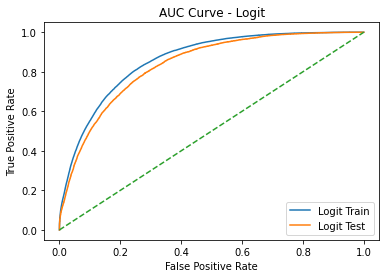

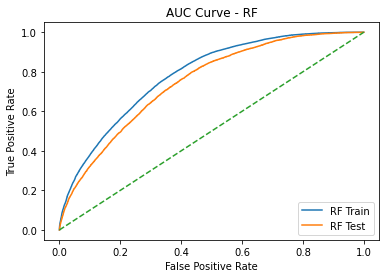

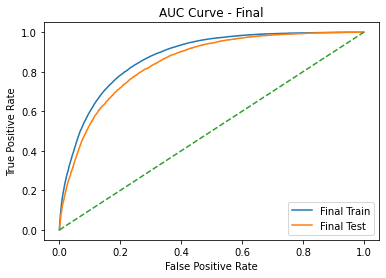

In [96]:
plt.title('AUC Curve - Logit')
plt.plot(fpr_logit_train, tpr_logit_train,label='Logit Train')
plt.plot(fpr_logit_test, tpr_logit_test,label='Logit Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")
plt.show()

plt.title('AUC Curve - RF')
plt.plot(fpr_rf_train, tpr_rf_train,label='RF Train')
plt.plot(fpr_rf_test, tpr_rf_test,label='RF Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")
plt.show()


plt.title('AUC Curve - Final')
plt.plot(fpr_final_train, tpr_final_train,label='Final Train')
plt.plot(fpr_final_test, tpr_final_test,label='Final Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")
plt.show()

In [97]:
test_target.head()

,customer_id_mskd,steps,target,rating,logit_proba,train_test,xgbrf_proba,fold,final_proba
1,002cbed46139d2c4476f10cc89146aaffb58676d8ab10c...,0.0,0,2,0.184715,test,0.290946,1,0.245221
2,00327b820298f4116898ed78740dc1f9ba7c569cd4baf2...,0.0,1,3,0.735450,test,0.547622,1,0.628469
4,0066b8ccbee0ccce3b762e7a2ad30b88dfb8948310f6bc...,0.0,0,2,0.017353,test,0.165326,1,0.101634
14,011a6aadea5fc482af4aad5a68e80f26cee9759e332cdc...,0.0,0,2,0.135647,test,0.214999,1,0.180843
15,0121a16b47d76b6ec956a62b817a87075d1e9d38d53865...,0.0,1,3,0.681221,test,0.354091,1,0.494898


In [98]:
test_target['high_risk'] = (test_target.rating == 3).astype(int)
test_target['medium_risk'] = (test_target.rating == 2).astype(int)
test_target['low_risk'] = (test_target.rating == 1).astype(int)

In [99]:
results = test_target.copy()

In [114]:
metrics = [f1_score, accuracy_score, precision_score, recall_score]
lowest_prob = 0.5/100
threshold_max = 1

order_assessment = ['high_risk','medium_risk','low_risk',]
plotting_list=[]

for risk_level in tqdm.tqdm_notebook(order_assessment):
    metrics_dict = {func.__name__:[] for func in metrics}
    metrics_dict['threshold'] = []
 
    
    
    for threshold in np.linspace(lowest_prob,0.9995, 1_000):
       
    
        if risk_level in ['high_risk','medium_risk']:
            binary = np.where((results.final_proba >= threshold) & (results.final_proba < threshold_max),1,0 )
        else:           
            binary = np.where(results.final_proba < threshold,1,0 )
            
            
        metrics_dict['threshold'].append(threshold)

        for metric in metrics:
            value_metric = metric(results[risk_level], binary)
            metrics_dict[metric.__name__].append(value_metric)
    
    temp = pd.DataFrame(metrics_dict)
    temp['risk_level'] = risk_level




    plotting_list.append(temp)
    # the threshold to flag a client as high risk will be determined by the highest F1-Score, since it accounts for the trade-off between recall and precision
    
    if risk_level == 'high_risk':
        threshold_high_risk = temp.loc[temp.risk_level == risk_level,:]
        threshold_high_risk.sort_values(by='f1_score',ascending=False,inplace=True)
        threshold_high_risk.reset_index(inplace=True)
        threshold_high_risk = threshold_high_risk.loc[0,'threshold']
        threshold_max = threshold_high_risk
    

In [115]:
plotting_list = pd.concat(plotting_list)

In [116]:
plotting_list.to_csv('plotting_results2.csv',index=False)

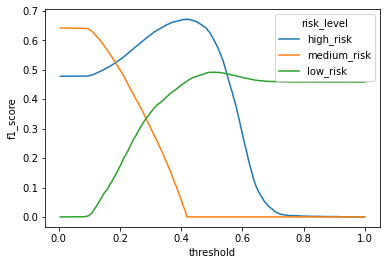

In [117]:
sns.lineplot(data = plotting_list, x = 'threshold', y='f1_score',hue='risk_level',)
plt.show()

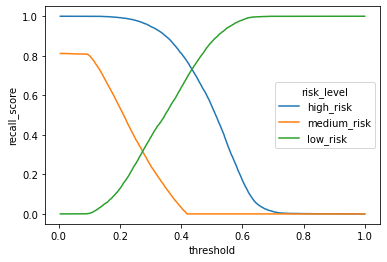

In [118]:
sns.lineplot(data = plotting_list, x = 'threshold', y='recall_score',hue='risk_level',)
plt.show()

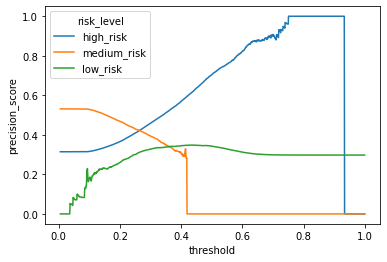

In [119]:
sns.lineplot(data = plotting_list, x = 'threshold', y='precision_score',hue='risk_level',)
plt.show()

In [120]:
# the threshold to flag a client as high risk will be determined by the highest F1-Score, since it accounts for the trade-off between recall and precision
threshold_high_risk = plotting_list.copy().loc[plotting_list.risk_level == 'high_risk',:]
threshold_high_risk.sort_values(by='f1_score',ascending=False,inplace=True)
threshold_high_risk.reset_index(inplace=True)
threshold_high_risk.head()

,index,f1_score,accuracy_score,precision_score,recall_score,threshold,risk_level
0,416,0.672127,0.763258,0.595229,0.771844,0.419126,high_risk
1,420,0.671973,0.765755,0.600247,0.763169,0.423108,high_risk
2,413,0.671958,0.760991,0.590988,0.778637,0.416140,high_risk
3,414,0.671882,0.761582,0.592141,0.776442,0.417135,high_risk
4,412,0.671791,0.760104,0.589414,0.780936,0.415144,high_risk


In [121]:
threshold_high_risk = threshold_high_risk.loc[0,'threshold']
threshold_high_risk


0.4191261261261262

In [122]:
threshold_high_risk

0.4191261261261262

In [129]:
f = (plotting_list.risk_level == 'medium_risk') & (plotting_list.threshold < threshold_high_risk)
threshold_low_risk = plotting_list.copy().loc[f,:]
threshold_low_risk.sort_values(by=['f1_score','threshold'],ascending=[False,False],inplace=True)
threshold_low_risk.head(50)


,f1_score,accuracy_score,precision_score,recall_score,threshold,risk_level
16,0.642419,0.649504,0.531536,0.811759,0.020928,medium_risk
15,0.642419,0.649504,0.531536,0.811759,0.019932,medium_risk
14,0.642419,0.649504,0.531536,0.811759,0.018937,medium_risk
13,0.642419,0.649504,0.531536,0.811759,0.017941,medium_risk
12,0.642419,0.649504,0.531536,0.811759,0.016946,medium_risk
11,0.642419,0.649504,0.531536,0.811759,0.015950,medium_risk
10,0.642419,0.649504,0.531536,0.811759,0.014955,medium_risk
9,0.642419,0.649504,0.531536,0.811759,0.013959,medium_risk
8,0.642419,0.649504,0.531536,0.811759,0.012964,medium_risk
7,0.642419,0.649504,0.531536,0.811759,0.011968,medium_risk


In [128]:
threshold_low_risk = threshold_low_risk.loc[0,'threshold']
threshold_low_risk

0.005